In [ ]:
import findspark
findspark.init()
import random
import pyspark

In [ ]:
import os
lehighId =  'team6' # Put here your Lehigh Id

config = pyspark.SparkConf().set('spark.executor.memory', '1024M')\
            .set('spark.cores.max', '6')\
            .set('spark.port.maxRetries','200')\
            .set('spark.ui.port', 4040 + hash(random.random())%200)\
            .set('spark.master', 'spark://polyp1:7077')\
            .set('spark.app.name', lehighId+" Project #3")

ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()
sc = ss.sparkContext

In [ ]:
from pyspark.sql.functions import *
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import MinMaxScaler
# from pyspark.mllib.linalg import *
import pandas as pd

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [ ]:
! ls /scratch/ISE495/2020_project_03/team-6

data_by_artist.csv  data_by_year.csv  data_w_genres.csv  spotify_dataset.csv
data_by_genres.csv  data.csv	      README.txt


Task1: Basic statistical analysis

1.   Histograms
2.   Mean and var of features
3.   Info about features



Task2: Time series analysis 
1. trend of popular songs and generes


Task3: Recommendation system

1) Content Based Song Recommendation to Users - Using the song features create a user profile (avg of item features, weighted avg if count is present). Calculate (user, item) similarity using random projection LSH (http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.BucketedRandomProjectionLSH)


*   User - Artist Recommendation (Recommending new artists to users)

*   User - Song Recommendation (Recommneding new songs to users)
*   Playlist - Song Recommendation (Recommending songs to be added to current playlists)



2) Matrix Factorization Method - create tuples (user, item, count) and then use the implicit ALS method to get the predictions on whether the user will respond to the item or not (http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.recommendation.ALS)


*   Can implicit preferences be created somehow?
*   Should hand design implicit parameter (alpha) based on the type of problem at hand
*   Obtained recommendation accuracy of less than 50% (suggesting songs at random) threshold for a resonable number of rank. Better performance can be expected at higher value of rank but comes at a great cost.
*   Need a custom weight defining formuale. Currently not supported by Spark under its ALS module


(https://ieeexplore.ieee.org/document/4781121/authors#authors)

(https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf)



In [ ]:
# File paths
artistDataPath = "/scratch/ISE495/2020_project_03/team-6/data_by_artist.csv"
genreDataPath = "/scratch/ISE495/2020_project_03/team-6/data_by_genres.csv"
yearDataPath = "/scratch/ISE495/2020_project_03/team-6/data_by_year.csv"
DataPath = "/scratch/ISE495/2020_project_03/team-6/data.csv"
spotifyDataPath = "/scratch/ISE495/2020_project_03/team-6/spotify_dataset.csv"
wgenresDataPath = "/scratch/ISE495/2020_project_03/team-6/data_w_genres.csv"

In [ ]:
! head "/scratch/ISE495/2020_project_03/team-6/data.csv"

In [ ]:
#Base Dataframes

artistdf = ss.read.csv(artistDataPath,header=True,inferSchema=True)
genredf = ss.read.csv(genreDataPath,header=True,inferSchema=True)
yeardf = ss.read.csv(yearDataPath,header=True,inferSchema=True)
datadf = ss.read.csv(DataPath,header=True,inferSchema=True,escape='\"',quote='\"') #Escape character set to "
w_genredf = ss.read.csv(wgenresDataPath,header=True,inferSchema=True)

spotifydf = ss.read.csv(spotifyDataPath,header=True,inferSchema=True)
spotifydf = spotifydf.select('user_id',col(' "artistname"').alias('artistname'), col(' "trackname"').alias("trackname"),col(' "playlistname"').alias('playlistname'))



In [ ]:
#Base RDDs

artistRDD = artistdf.rdd.map(list)
genreRDD = genredf.rdd.map(list)
yearRDD = yeardf.rdd.map(list)
dataRDD = datadf.rdd.map(list)
w_genreRDD = w_genredf.rdd.map(list)

spotifyRDD = spotifydf.rdd.map(list) 

In [ ]:
datadf.show()

+------------+--------------------+------------------+-----------+-------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+--------------------+-----------------+-------------------+----+
|acousticness|             artists|      danceability|duration_ms| energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|         speechiness|            tempo|            valence|year|
+------------+--------------------+------------------+-----------+-------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+--------------------+-----------------+-------------------+----+
|       0.995| ['Carl Woitschach']|             0.708|     158648|  0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151|            -12.428|   1|Singende Bataillo...|         0|  

In [ ]:
# Removing songs of duration less than half minute and more than a hour (60 minutes)
datadf = ss.read.csv(DataPath,header=True,inferSchema=True,escape='\"',quote='\"')
data_df = datadf.withColumn('artists',translate('artists', '[','')).\
                withColumn('artists',translate('artists', ']','')).\
                withColumn('artists',translate('artists', "'",'')).\
                withColumn('artists',split('artists',',')).\
                withColumn("duration_ms",col("duration_ms")/60000).withColumnRenamed("duration_ms","duration")
dataDF = data_df.where((data_df['duration'] >= 0.5)&(data_df['duration'] <= 60))
dataDF2 = dataDF.select(col("*"),explode(dataDF.artists).alias('artistname'))

In [ ]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import col

dataDF2 = dataDF.select(col("*"),explode(dataDF.artists).alias('artistname'))

In [ ]:
dataDF2.show()

+------------+--------------------+------------------+------------------+------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+-------------------+----+-------------------+
|acousticness|             artists|      danceability|          duration|energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|            tempo|            valence|year|         artistname|
+------------+--------------------+------------------+------------------+------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+-------------------+----+-------------------+
|       0.995|   [Carl Woitschach]|             0.708|2.6441333333333334| 0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151|  

In [ ]:
#Feature dataset is clean and does not have any null values
#Check for null values and drop the rows which have null enteries
spotifydf = ss.read.csv(spotifyDataPath,header=True,inferSchema=True)
spotifydf = spotifydf.select('user_id',col(' "artistname"').alias('artistname'), col(' "trackname"').alias("trackname"),col(' "playlistname"').alias('playlistname'))
spotifydf.select([count(when(isnull(c), c)).alias(c) for c in spotifydf.columns]).show()
spotifydf = spotifydf.na.drop()

+-------+----------+---------+------------+
|user_id|artistname|trackname|playlistname|
+-------+----------+---------+------------+
|      0|     33562|       82|          45|
+-------+----------+---------+------------+



In [ ]:
joinedDF = spotifydf.join(dataDF2,(dataDF2.name==spotifydf.trackname)&(dataDF2.artistname==spotifydf.artistname))

In [ ]:
joinedDF.show()

+--------------------+-------------+--------------------+--------------------+------------------+---------------+------------------+------------------+------------------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+------------------+------------------+----+-------------+
|             user_id|   artistname|           trackname|        playlistname|      acousticness|        artists|      danceability|          duration|            energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|             tempo|           valence|year|   artistname|
+--------------------+-------------+--------------------+--------------------+------------------+---------------+------------------+------------------+------------------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------

In [ ]:
joinedDF.count()

3931817

**Exploratory Analysis**

Feature Datasets and Playlist Dataset

In [ ]:
print("Total number of artists: " + str(artistdf.count()))
print("Total number of genres: " + str(genredf.count()))
print("Total number of songs: " + str(datadf.select('name').distinct().count()))
print("Total number of years: " + str(yeardf.count()))


Total number of artists: 27621
Total number of genres: 2664
Total number of songs: 132940
Total number of years: 100


In [ ]:
datadf.count()-data_df.count()

36969

In [ ]:
print('Total number of users in playlist dataset: ' + str(spotifydf.select("user_id").distinct().count()))
print('Total number of artists in playlist dataset: ' + str(spotifydf.select('artistname').distinct().count()))
print('Total number of songs in playlist dataset: ' + str(spotifydf.select('trackname').distinct().count()))
print('Total number of playlists in playlist dataset: ' + str(spotifydf.select('playlistname').distinct().count()))

Total number of users in playlist dataset: 15914
Total number of artists in playlist dataset: 289810
Total number of songs in playlist dataset: 2009677
Total number of playlists in playlist dataset: 161327


Time Series Analysis

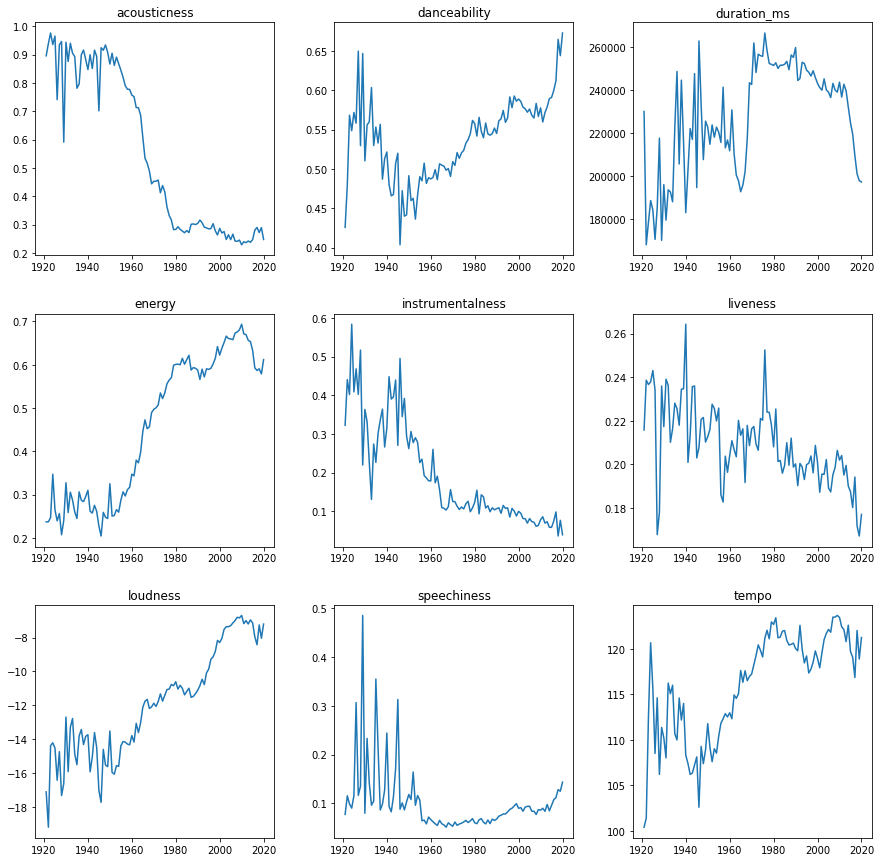

In [ ]:
y = yeardf.columns[1:10]

fig, axs = plt.subplots(3,3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.25, wspace=0.25)

axs = axs.ravel()

for i in range(len(y)):
    axs[i].plot(yeardf.select('year').collect(),yeardf.select(y[i]).collect())
    axs[i].set_title(y[i])

In [ ]:
#top 20 artists by number of tracks
spotifydf.createOrReplaceTempView('spotify_Table')
ss.sql("SELECT artistname,COUNT(DISTINCT trackname) FROM spotify_Table GROUP BY artistname ORDER BY COUNT(DISTINCT trackname) DESC").show(truncate=False)

+-----------------------+-------------------------+
|artistname             |count(DISTINCT trackname)|
+-----------------------+-------------------------+
|Johann Sebastian Bach  |6967                     |
|Various Artists        |6784                     |
|Wolfgang Amadeus Mozart|5872                     |
|Vitamin String Quartet |3651                     |
|Frank Sinatra          |3408                     |
|Ludwig van Beethoven   |3404                     |
|Grateful Dead          |3396                     |
|Ella Fitzgerald        |3307                     |
|Johnny Cash            |2500                     |
|Lata Mangeshkar        |2479                     |
|Ennio Morricone        |2397                     |
|George Frideric Handel |2389                     |
|Antonio Vivaldi        |2340                     |
|Billie Holiday         |2327                     |
|Miles Davis            |2276                     |
|Ilaiyaraaja            |2241                     |
|Louis Armst

In [ ]:
#top20 playlists based on number of users listening to those playlists
ss.sql("SELECT playlistname,COUNT(DISTINCT user_id) FROM spotify_Table GROUP BY playlistname ORDER BY COUNT(DISTINCT user_id) DESC").show(truncate=False)

+----------------------------------+-----------------------+
|playlistname                      |count(DISTINCT user_id)|
+----------------------------------+-----------------------+
|Starred                           |5016                   |
|Liked from Radio                  |3125                   |
|Favoritas de la radio             |745                    |
|My Shazam Tracks                  |424                    |
|Christmas                         |312                    |
|Rock                              |202                    |
|Chill                             |175                    |
|Country                           |172                    |
|Classical                         |161                    |
|Jazz                              |154                    |
| The Breaks Over""                |145                    |
|Daft Punk - Random Access Memories|143                    |
|2014                              |143                    |
|Running                

In [ ]:
#top20 tracks based on number of users listening to those tracks
ss.sql("SELECT trackname,COUNT(DISTINCT user_id) FROM spotify_Table GROUP BY trackname ORDER BY COUNT(DISTINCT user_id) DESC").show(truncate=False)

+-------------+-----------------------+
|trackname    |count(DISTINCT user_id)|
+-------------+-----------------------+
|Intro        |3872                   |
|Home         |3504                   |
|Runaway      |2434                   |
|Closer       |2431                   |
|Radioactive  |2337                   |
|Hold On      |2260                   |
|Stay         |2198                   |
|Alive        |2130                   |
|Forever      |2110                   |
|Trouble      |2072                   |
|Heaven       |2057                   |
|Wake Me Up   |2043                   |
|Happy        |2027                   |
|Crazy        |2012                   |
|Kids         |1980                   |
|Breathe      |1978                   |
|Dreams       |1976                   |
|One          |1963                   |
|Angel        |1962                   |
|Midnight City|1899                   |
+-------------+-----------------------+
only showing top 20 rows



In [ ]:
#Create a dataframe grouped on trackname and with columns having all unique enteries
spotify_df = spotifydf.groupBy('trackname').agg(F.collect_set("user_id").alias('user_ids'),\
                                                F.collect_set("playlistname").alias('playlists'),\
                                                F.collect_set("artistname").alias('artists'))

spotify_df.show(5,truncate=False)

+----------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------+
|trackname                                                             |user_ids                                                                                                                                                                                                                                      |playlists                                                                                                                                           

In [ ]:
#Function to create a flat list of all artists who are associated with a song. 
#Since the dataframe interprets it as a string, we need to split the enteries for single song and then groupby the song name to get all artists

def listoflists(s):
  k = s[0]
  v = s[1].replace('[','').replace(']','').replace("'",'').split(',')
  return k,v

artistdata = datadf.select('name','artists').rdd.map(tuple).map(listoflists).\
              toDF(['name','artists']).groupBy('name').\
              agg(F.collect_set('artists').alias('artist')).\
              withColumn("artist",flatten('artist'))

#join data_df and artistdata and convert duration from millisecond to minutes
data_df_joined = data_df.join(artistdata,'name').withColumn("duration_ms",col("duration_ms")/60000).withColumnRenamed("duration_ms","duration")

print('We have ' +str(data_df_joined.where(data_df_joined['duration'] <= 0.5).count()) + ' songs which are less than 30 seconds')
print('We have ' +str(data_df_joined.where(data_df_joined['duration'] >= 60).count()) + ' songs which are more than 1 hour')

#Filter out songs less than 30 secs and more than 1 hour to avoid improper scaling of data
dataDF = data_df_joined.where((data_df_joined['duration'] >= 0.5)&(data_df_joined['duration'] <= 60))

We have 150 songs which are less than 30 seconds
We have 7 songs which are more than 1 hour


In [ ]:
#Join the spotify dataset and feature dataset based on the trackname
joined_df = dataDF.join(spotify_df,dataDF.name==spotify_df.trackname)

In [ ]:
print('Total number of enteries are ' + str(joined_df.count()))

Total number of enteries are 72204


In [ ]:
#This is a joined dataset which contains unique songs along with associated features and list of playlists, userids and artists
#Need to combine the two artists column and get a set of artists associated with that song
joined_df.show(5,truncate=False)

+--------------------------------------------+----+--------------------+------------------+-----------------+------------------+--------+-------------------+---+--------+------------------+----------+-----------+------------------+-------+----------+----------------------+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Analysis of features
# The features are well balanced and thus no exclusion is necessary 
dataDF.summary().show(truncate=False)

+-------+-------------------------------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+
|summary|name                                       |mode              |acousticness      |danceability       |duration          |energy            |explicit           |instrumentalness   |key              |liveness           |loudness           |popularity        |speechiness        |tempo             |valence            |
+-------+-------------------------------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+
|count  |132789       

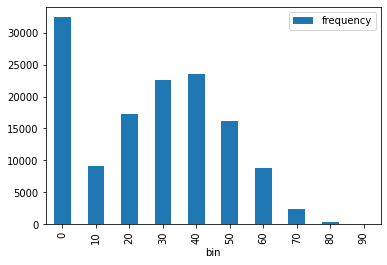

In [ ]:
popularity_histogram = dataDF.select('popularity').rdd.flatMap(lambda x: x).histogram([0,10,20,30,40,50,60,70,80,90,100])

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*popularity_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [ ]:
# Total number of tracks with zero popularity. Popularity rating depends on the number of times a track is played and if it has been played recently or not
# High popularity of song means that it has been played a lot recently (https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/)

zero_popularity_count = dataDF.filter(dataDF['popularity'] == 0).count()
print("There are are %d number of tracks with zero popularity rating" % zero_popularity_count)

There are are 23638 number of tracks with zero popularity rating


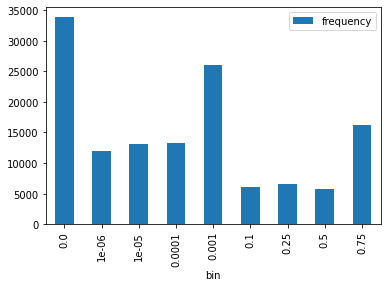

In [ ]:
# Plotting Instrumentalness histogram to understand its data distribution
# This feature represents the extent of instrumentalness in the song. Values greater than 0.5 represent instrumental tracks and tracks with value 0 represent 
# that the track contained large amount of vocals (https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/)

instrumentalness_histogram = dataDF.select('instrumentalness').rdd.flatMap(lambda x: x).histogram([0,0.000001,0.00001,0.0001,0.001,0.1,0.25,0.5,0.75,1])

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*instrumentalness_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');


## User - Artist Recommendation using LSH

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import MinMaxScaler
# from pyspark.mllib.linalg import *
import pandas as pd

In [ ]:
# Building Hash projections of Artists and in order to do that artist profiles are to be made into vectors
# Convert the duration of songs to minutes and remove any outliers
# Convert key into one hot encoded vector and remove count as an feature for the artists (we want to build artists profile solely based on their track features)
# Convert each artists features into a dense vector (mapping it into rdd and then again to df)

# Join spotify df and artist df by artistname and map it intoa rdd
# Pick a random user and create a artist profile for that user (it will be weighted average as the features will be weighted by their count)
# Query that user to find top 10 artists and then validate by calculating cosine similarity (or euclidian distance) b/w suggested artists and the top 5 artists
# the user has listened to by count 


In [ ]:
# Convert duration from ms -> minutes and remove any outlier
# ----------------------------------------- #
artistdf = ss.read.csv(artistDataPath,header=True,inferSchema=True)
artistdf = artistdf.withColumn('artists',translate('artists', '"','')).withColumn('artists',translate('artists', '”', ''))
artistdf = artistdf.withColumn('duration',col("duration_ms")/60000)
artistdf.show(2, truncate=False)
artistdf.printSchema()

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|
+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+
|Cats 1981 Original London Cast|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18067500000000009|115.9835          |0.33443333

In [ ]:
# Convert key feature into a one hot encoeded vector 
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model = ohe.fit(artistdf)
artistdf_key_encoded = model.transform(artistdf)
artistdf_key_encoded.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|key_vector    |
+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+
|Cats 1981 Original London Cast|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18

In [ ]:
# Assemble all features into one to create a single vector
audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'count', 'key_vector']
assembler = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
artistdf_feature = assembler.transform(artistdf_key_encoded)
artistdf_feature.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|key_vector    |features                                                                                                                                                                                                     

In [ ]:
# Creating artists feature vectos for user profile tags creation (count to be eliminated as feature not present in genres)
audio_feature_columns_id = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'key_vector']
assembler_id = VectorAssembler(
    inputCols=audio_feature_columns_id,
    outputCol="features")
artistdf_feature_id = assembler_id.transform(artistdf_key_encoded)
artistdf_feature_id.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|key_vector    |features                                                                                                                                                                                                             

In [ ]:
# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model = mmScaler.fit(artistdf_feature)
artistdf_scaled = model.transform(artistdf_feature)
artistdf_scaled.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo           

In [ ]:
# Scaling the reduced artists features for user id tag as well
mmScaler_id = MinMaxScaler(outputCol="scaled_features")
mmScaler_id.setInputCol("features")
model_id = mmScaler_id.fit(artistdf_feature_id)
artistdf_scaled_id = model_id.transform(artistdf_feature_id)
# artistdf_scaled.show(2, truncate=False)

In [ ]:
# Convert sparse vectors into dense vectors
data_feature_rdd = artistdf_scaled.select(['artists', 'scaled_features']).rdd.map(list)
artistdF_dense = data_feature_rdd.map(lambda kv: (kv[0], DenseVector(kv[1].toArray()))).toDF()
artistdF_dense = artistdF_dense.withColumnRenamed('_1', 'artists').withColumnRenamed('_2', 'scaled_features')
artistdF_dense.printSchema()
artistdF_dense.show(2, truncate=False)

root
 |-- artists: string (nullable = true)
 |-- scaled_features: vector (nullable = true)

+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |scaled_features                                                                                                                                                                                                                                                                             |
+------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# COnverting the sparse artists vectors for the user profile id into dense vector as well
data_feature_rdd_id = artistdf_scaled_id.select(['artists', 'scaled_features']).rdd.map(list)
artistdF_dense_id = data_feature_rdd_id.map(lambda kv: (kv[0], DenseVector(kv[1].toArray()))).toDF()
artistdF_dense_id = artistdF_dense_id.withColumnRenamed('_1', 'artists').withColumnRenamed('_2', 'scaled_features')

In [ ]:
# Create Hash Projections
brp = BucketedRandomProjectionLSH(inputCol='scaled_features', outputCol='hashed_projections', seed=123, numHashTables=5, bucketLength=10)
brp_model = brp.fit(artistdF_dense)
artistdF_hashed = brp_model.transform(artistdF_dense)
artistdF_hashed.show(2, truncate=False)

+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|artists                       |scaled_features                                                                                                                                                                                                                                                                             |hashed_projections                     |
+------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Get the spotify playlist dataset and Check for null values and drop the rows which have null enteries
spotifydf = ss.read.csv(spotifyDataPath,header=True,inferSchema=True)
spotifydf = spotifydf.select('user_id',col(' "artistname"').alias('artistname'), col(' "trackname"').alias("trackname"),col(' "playlistname"').alias('playlistname'))
spotifydf.select([count(when(isnull(c), c)).alias(c) for c in spotifydf.columns]).show()
spotifydf = spotifydf.na.drop()
spotifydf.show(5, truncate=False)

+-------+----------+---------+------------+
|user_id|artistname|trackname|playlistname|
+-------+----------+---------+------------+
|      0|     33562|       82|          45|
+-------+----------+---------+------------+

+--------------------------------+--------------------------------+-----------------------------------------------------+--------------+
|user_id                         |artistname                      |trackname                                            |playlistname  |
+--------------------------------+--------------------------------+-----------------------------------------------------+--------------+
|9cc0cfd4d7d7885102480dd99e7a90d6|Elvis Costello                  |(The Angels Wanna Wear My) Red Shoes                 |HARD ROCK 2010|
|9cc0cfd4d7d7885102480dd99e7a90d6|Elvis Costello & The Attractions|(What's So Funny 'Bout) Peace, Love And Understanding|HARD ROCK 2010|
|9cc0cfd4d7d7885102480dd99e7a90d6|Tiffany Page                    |7 Years Too Late           

In [ ]:
# Join the artist and playlist df
joined_artist_df = spotifydf.join(artistdF_dense, spotifydf.artistname==artistdF_dense.artists)
joined_artist_df.show(5, truncate=False)

+--------------------------------+----------+-------------------+-----------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname          |playlistname     |artists|scaled_features                                                                                                                                                                                                                                                                              |
+--------------------------------+----------+-------------------+-----------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Joining the spotify df and the new artist df required for user id tag 
joined_artist_df_id = spotifydf.join(artistdF_dense_id, spotifydf.artistname==artistdF_dense_id.artists)
joined_artist_df_id.show(2, truncate=False)

+--------------------------------+----------+-------------------+------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname          |playlistname|artists|scaled_features                                                                                                                                                                                                                                                         |
+--------------------------------+----------+-------------------+------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print("The total number of observations in the joined df is", joined_artist_df.count())
print("The total number of unique artists in the joined df is", joined_artist_df.select('artistname').distinct().count())
print("The total number of unique users in the joined df is", joined_artist_df.select('user_id').distinct().count())

The total number of observations in the joined df is 8547183
The total number of unique artists in the joined df is 16644
The total number of unique artists in the joined df is 15601


In [ ]:
user_distinct_artist = joined_artist_df.groupby('user_id').agg(countDistinct('artistname').alias('distinct_artist'))

+--------------------------------+---------------+
|user_id                         |distinct_artist|
+--------------------------------+---------------+
|2c0c379f89a3dac1c64e04ef0340b75c|6              |
|1c5ff5dce0c7f6011f748461fea511d7|5              |
|0360dadb07b1f2aaeb15f0f210237302|8              |
|056545ff6bee20986204f331df00328d|10             |
|920cfa37e3ec93e348950670b6195069|6              |
|a69804103a1cc1310f5c3fa9fba5c4ce|1              |
|d88386da3cf26ecc10ba81cf01f39d71|3              |
|a2fe5f2f6c81adf9532a97304b528d7e|2              |
|c816c5059da625c062aee20ed1424de2|6              |
|634286dd46e2a30a807ef140db7f296e|7              |
+--------------------------------+---------------+
only showing top 10 rows



In [ ]:
# Selected a random user and Checking what artists did this user listened to?
# The user can be divided largely into 3 groups based on the distinct number of artists the user listened to: 
#       1) Large Artist Base - (500+)
#       2) Medium Artist Base - (100+)
#       3) Low Artist Base - (10+)
# We will select a random user from each group and test our model
# Finding users from the 3 groups

user_distinct_artist.filter(col('distinct_artist') <= 10).sort(col('distinct_artist').desc()).show(10, truncate=False)
user_distinct_artist.filter(col('distinct_artist') <= 100).sort(col('distinct_artist').desc()).show(10, truncate=False)
user_distinct_artist.filter(col('distinct_artist') <= 500).sort(col('distinct_artist').desc()).show(10, truncate=False)

+--------------------------------+---------------+
|user_id                         |distinct_artist|
+--------------------------------+---------------+
|f2ed2c13b1ee9c9b490b303d700eda9f|500            |
|c126e3612077c80a3dcf496c882533f1|500            |
|478b6343aecfa493c489d7ebdda36b8c|500            |
|1ba47c0c9d49d911e86cc0d666402246|499            |
|376b6b26d087cb19b0a5981b38565b0f|498            |
|91d36e483e6ca77ea5b2b12c13e69bc7|498            |
|20249f8f758d196e0ee5f242697d28be|497            |
|761e82fdf3ae3999f185632a6ef6775c|497            |
|5e288c7e0c059cc56d7ac1646942a39e|497            |
|13e999f0fe9591bcf4f4eea2379b9a61|496            |
+--------------------------------+---------------+
only showing top 10 rows



User 1 -> 1a005fecd058d6383e2db01d06a74743 -> 10 distinct artists

User 2 -> 2b9384c530a562c8b2b931b7a5da9773 -> 100 distinct artists

User 3 -> f2ed2c13b1ee9c9b490b303d700eda9f -> 500 distinct artists

In [ ]:
joined_artist_df.createOrReplaceTempView('joined_artist_table')

# ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = 'f2ed2c13b1ee9c9b490b303d700eda9f' GROUP BY artistname ORDER BY COUNT(artistname) DESC").show()
# ss.sql("SELECT user_id, COUNT(DISTINCT artistname) FROM joined_artist_table WHERE COUNT(DISTINCT artistname) <= 10 GROUP BY user_id ORDER BY COUNT(DISTINCT artistname) DESC LIMIT 10").show(truncate=False)
# ss.sql("SELECT user_id, COUNT(DISTINCT artistname) FROM joined_artist_table GROUP BY user_id ORDER BY COUNT(DISTINCT artistname) LIMIT 10").show(truncate=False)

# user_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id == 'd481556edb513b3d2ea28ed7a68491c4' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
# ss.sql("SELECT COUNT(artistname) FROM joined_artist_table WHERE user_id == 'd481556edb513b3d2ea28ed7a68491c4'").show()

In [ ]:
user_1_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = '1a005fecd058d6383e2db01d06a74743' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
user_2_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = '2b9384c530a562c8b2b931b7a5da9773' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
user_3_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = 'f2ed2c13b1ee9c9b490b303d700eda9f' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()

In [ ]:
# Creating artists profile for the 3 users
joined_artist_rdd = joined_artist_df.rdd.map(list)
joined_artist_rdd.take(2)

[['b5daa64b8ae6b352e5c77f3c4e832181',
  '*NSYNC',
  "Tearin' Up My Heart",
  "Get Movin'",
  '*NSYNC',
  DenseVector([0.1574, 0.6512, 0.7193, 0.0405, 0.0036, 0.6207, 0.4821, 0.5267, 0.2194, 0.8798, 0.0697, 1.0, 0.0243, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])],
 ['ccdbbd7f10743262dcb0081a251ae555',
  '*NSYNC',
  'Bye Bye Bye',
  'Fascinate',
  '*NSYNC',
  DenseVector([0.1574, 0.6512, 0.7193, 0.0405, 0.0036, 0.6207, 0.4821, 0.5267, 0.2194, 0.8798, 0.0697, 1.0, 0.0243, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]]

In [ ]:
# Creating the artist profile for that user (the profile would be a weighted average)

user_1_artist_profile = joined_artist_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == '1a005fecd058d6383e2db01d06a74743')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()
user_2_artist_profile = joined_artist_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == '2b9384c530a562c8b2b931b7a5da9773')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()
user_3_artist_profile = joined_artist_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == 'f2ed2c13b1ee9c9b490b303d700eda9f')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()

In [ ]:
user_1_artist_profile[0]

DenseVector([0.1719, 0.6321, 0.6785, 0.042, 0.1063, 0.6541, 0.4399, 0.5693, 0.1905, 0.8184, 0.0421, 0.9545, 0.0252, 0.0909, 0.0, 0.0455, 0.0455, 0.5, 0.0909, 0.0, 0.1818, 0.0, 0.0455, 0.0])

In [ ]:
# Finding similar artists for the user using the nearest neighbour module of the randomized projection LSH
user_1_artist_neighbours = brp_model.approxNearestNeighbors(artistdF_hashed, user_1_artist_profile[0], 10, distCol='Distance_Measure').collect()
user_2_artist_neighbours = brp_model.approxNearestNeighbors(artistdF_hashed, user_2_artist_profile[0], 10, distCol='Distance_Measure').collect()
user_3_artist_neighbours = brp_model.approxNearestNeighbors(artistdF_hashed, user_3_artist_profile[0], 10, distCol='Distance_Measure').collect()

In [ ]:
user_3_artist_neighbours

[Row(artists='Paula Cole', scaled_features=DenseVector([0.2892, 0.5903, 0.5572, 0.0536, 0.0, 0.6031, 0.5088, 0.5954, 0.1938, 0.8523, 0.0437, 1.0, 0.0035, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), hashed_projections=[DenseVector([-1.0]), DenseVector([0.0]), DenseVector([-1.0]), DenseVector([-1.0]), DenseVector([0.0])], Distance_Measure=0.4062117136992124),
 Row(artists='Industria del Amor', scaled_features=DenseVector([0.2741, 0.5578, 0.5535, 0.0341, 0.0015, 0.6742, 0.4502, 0.5737, 0.2129, 0.8047, 0.039, 1.0, 0.0136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), hashed_projections=[DenseVector([-1.0]), DenseVector([0.0]), DenseVector([-1.0]), DenseVector([-1.0]), DenseVector([0.0])], Distance_Measure=0.4117210286892202),
 Row(artists='Mick Jagger', scaled_features=DenseVector([0.2139, 0.6504, 0.6872, 0.0476, 0.0274, 0.5641, 0.4649, 0.5663, 0.1203, 0.8349, 0.0736, 1.0, 0.0035, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), hashed_projections=[DenseVect

In [ ]:
from pyspark.ml.feature import PCA, PCAModel

In [ ]:
# Map the artists features into 2-D space using PCA to visualize the data and the predictions 
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
model_pca = pca.fit(artistdF_dense)
artistdF_pca = model_pca.transform(artistdF_dense)
artistdF_pca.show(5, truncate=False)

+-------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+
|artists                                                      |scaled_features                                                                                                                                                                                                                                                                               |pca_features                             |
+-------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
user_1_recommended_artists = []
user_1_listened_artist = []
for i in user_1_artist_neighbours:
  user_1_recommended_artists.append(i.artists)
for i in user_1_artist_count:
  user_1_listened_artist.append(i.artistname)

In [ ]:
# Top 10 Artists Recommended to the 3 users by the LSH model
user_1_recommended_artists = []
user_1_recommended_artist_x = []
user_1_recommended_artist_y = []

user_2_recommended_artists = []
user_2_recommended_artist_x = []
user_2_recommended_artist_y = []

user_3_recommended_artists = []
user_3_recommended_artist_x = []
user_3_recommended_artist_y = []

for i in user_1_artist_neighbours:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artists).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_recommended_artists.append((i.artists, coordinate))
  user_1_recommended_artist_x.append(coordinate[0])
  user_1_recommended_artist_y.append(coordinate[1])

for i in user_2_artist_neighbours:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artists).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_recommended_artists.append((i.artists, coordinate))
  user_2_recommended_artist_x.append(coordinate[0])
  user_2_recommended_artist_y.append(coordinate[1])

for i in user_3_artist_neighbours:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artists).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_recommended_artists.append((i.artists, coordinate))
  user_3_recommended_artist_x.append(coordinate[0])
  user_3_recommended_artist_y.append(coordinate[1])

user_3_recommended_artists

[('Paula Cole', array([0.28833075, 1.08792407])),
 ('Industria del Amor', array([0.27784009, 1.08861629])),
 ('Mick Jagger', array([0.37492812, 1.10834063])),
 ('Bertie Higgins', array([0.19543854, 1.06369981])),
 ('Frankie Valli', array([0.19542927, 1.0642212 ])),
 ('Collective Soul', array([0.40287414, 1.11724929])),
 ('The Bangles', array([0.39844198, 1.12197635])),
 ('G. Love & Special Sauce', array([0.31005065, 1.09492559])),
 ('Pablo Olivares', array([0.34369542, 1.10048845])),
 ('Mike & The Mechanics', array([0.20691348, 1.06368147]))]

In [ ]:
# The top 10 artists listened by the three users by their count
user_1_listened_artist = []
user_1_listened_artist_x = []
user_1_listened_artist_y = []

user_2_listened_artist = []
user_2_listened_artist_x = []
user_2_listened_artist_y = []

user_3_listened_artist = []
user_3_listened_artist_x = []
user_3_listened_artist_y = []

for i in user_1_artist_count:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_listened_artist.append((i.artistname, coordinate))
  user_1_listened_artist_x.append(coordinate[0])
  user_1_listened_artist_y.append(coordinate[1])

for i in user_2_artist_count:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_listened_artist.append((i.artistname, coordinate))
  user_2_listened_artist_x.append(coordinate[0])
  user_2_listened_artist_y.append(coordinate[1])

for i in user_3_artist_count:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_listened_artist.append((i.artistname, coordinate))
  user_3_listened_artist_x.append(coordinate[0])
  user_3_listened_artist_y.append(coordinate[1])

user_3_listened_artist

[('Madonna', array([0.35130136, 1.16235194])),
 ('Prince', array([0.3824037 , 1.11730787])),
 ('Wendy & Lisa', array([0.57298959, 1.13042296])),
 ('Panic! At The Disco', array([0.51454401, 1.11426418])),
 ('Diana Ross', array([0.16557685, 0.97995219])),
 ('Cobra Starship', array([0.88403589, 0.52172799])),
 ('Fall Out Boy', array([0.59548681, 1.19064875])),
 ('Janet Jackson', array([0.43552875, 1.13067254])),
 ('Fleetwood Mac', array([0.16829149, 1.01558118])),
 ('My Chemical Romance', array([0.46825868, 1.14498418]))]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
user_2_listened_artist[0:3]

[('Manic Street Preachers', array([0.42487532, 1.17729303])),
 ('Jamie T', array([0.53165212, 1.41391402])),
 ('The Breeders', array([0.14197417, 0.92419608]))]

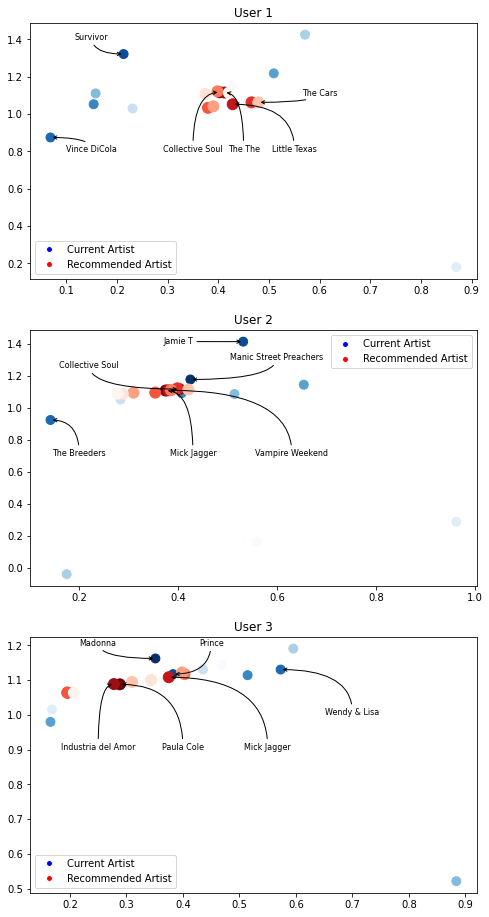

In [ ]:
fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

priority_list = [10,9,8,7,6,5,4,3,2,1]

legend_elements = [Line2D([0], [0], color='w', marker='o', markerfacecolor='b', label='Current Artist'),
                   Line2D([0], [0], color='w', marker='o', markerfacecolor='r', label='Recommended Artist'),
                   ]

ax1.scatter(user_1_listened_artist_x, user_1_listened_artist_y, s=80, c=priority_list, cmap='Blues', marker="o", edgecolors='face')
ax1.scatter(user_1_recommended_artist_x, user_1_recommended_artist_y,  s=120, c=priority_list, cmap='Reds', marker="o", edgecolors='face')

ax2.scatter(user_2_listened_artist_x, user_2_listened_artist_y, s=80, c=priority_list, cmap='Blues', marker="o", edgecolors='face')
ax2.scatter(user_2_recommended_artist_x, user_2_recommended_artist_y, s=120, c=priority_list, cmap='Reds', marker="o", edgecolors='face')

ax3.scatter(user_3_listened_artist_x, user_3_listened_artist_y, s=80, c=priority_list, cmap='Blues', marker="o", edgecolors='face')
ax3.scatter(user_3_recommended_artist_x, user_3_recommended_artist_y, s=120, c=priority_list, cmap='Reds', marker="o", edgecolors='face')

for i in user_1_listened_artist:
  if i[0] == 'The Cars':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.6, 1.1), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Survivor':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.15, 1.4), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Vince DiCola':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.15, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")

for i in user_1_recommended_artists:
  if i[0] == 'The The':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.45, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Collective Soul':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.35, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Little Texas':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.55, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
    
for i in user_2_listened_artist:
  if i[0] == 'Manic Street Preachers':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.6, 1.3), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Jamie T':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.4, 1.4), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'The Breeders':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.2, 0.7), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")

for i in user_2_recommended_artists:
  if i[0] == 'Mick Jagger':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.43, 0.7), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Collective Soul':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.22, 1.25), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Vampire Weekend':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.63, 0.7), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
    
for i in user_3_listened_artist:
 
  if ((0.35 < i[1][0] < 0.45) and (1.1 < i[1][1] < 1.2)):
    if i[0] == "Madonna":
      ax3.annotate(i[0], (i[1][0],i[1][1]), (0.25, 1.2), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
    if i[0] == "Prince":
      ax3.annotate(i[0], (i[1][0],i[1][1]), (0.45, 1.2), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
  if i[0] == 'Wendy & Lisa':
      ax3.annotate(i[0], (i[1][0],i[1][1]), (0.7, 1), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
      
for i in user_3_recommended_artists:
  if i[0] == 'Paula Cole':
    ax3.annotate(i[0], (i[1][0],i[1][1]), (0.4, 0.9), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
  if i[0] == 'Industria del Amor':
    ax3.annotate(i[0], (i[1][0],i[1][1]), (0.25, 0.9), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
  if i[0] == 'Mick Jagger':
    ax3.annotate(i[0], (i[1][0],i[1][1]), (0.55, 0.9), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
    
ax1.set_title('User 1')
ax2.set_title('User 2')
ax3.set_title('User 3')

ax1.legend(handles=legend_elements, loc='lower left')
ax2.legend(handles=legend_elements, loc='upper right')
ax3.legend(handles=legend_elements, loc='lower left')

plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
artistdF_dense.show(2, truncate=False)

+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |scaled_features                                                                                                                                                                                                                                                                             |
+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Cats 1981 Original London Cast|[0.57739290495

In [ ]:
user_1_listened_artist[0:3]

['The Cars', 'Survivor', 'Vince DiCola']

In [ ]:
# Cosine Similarity for user 1 
user_1_top_3_listened = []
user_1_top_3_r = []

for i in user_1_listened_artist[0:3]:
  user_1_top_3_listened.append(i)
for i in user_1_recommended_artists[0:3]:
  user_1_top_3_r.append(i)

user_1_top_3_l_pd = artistdF_dense.filter((col('artists') == user_1_top_3_listened[0]) | (col('artists') == user_1_top_3_listened[1]) | (col('artists') == user_1_top_3_listened[2])).collect()
user_1_top_3_r_pd = artistdF_dense.filter((col('artists') == user_1_top_3_r[0]) | (col('artists') == user_1_top_3_r[1]) | (col('artists') == user_1_top_3_r[2])).collect()

user_1_listened_array = np.array([user_1_top_3_l_pd[0].scaled_features.toArray(), user_1_top_3_l_pd[1].scaled_features.toArray(),  user_1_top_3_l_pd[2].scaled_features.toArray()])
user_1_recommended_array = np.array([user_1_top_3_r_pd[0].scaled_features.toArray(), user_1_top_3_r_pd[1].scaled_features.toArray(), user_1_top_3_r_pd[2].scaled_features.toArray()])

In [ ]:
user_1_top_3_listened

['The Cars', 'Survivor', 'Vince DiCola']

In [ ]:
user_1_similarity_matrix = cosine_similarity(user_1_listened_array, user_1_recommended_array)
user_1_similarity_matrix

array([[0.87368485, 0.77622551, 0.86828202],
       [0.8841403 , 0.99744603, 0.8866511 ],
       [0.78794648, 0.68279092, 0.79785186]])

In [ ]:
# Cosine Similarity for User 2

user_2_top_3_listened = []
user_2_top_3_r = []

for i in user_2_listened_artist[0:3]:
  user_2_top_3_listened.append(i[0])
for i in user_2_recommended_artists[0:3]:
  user_2_top_3_r.append(i[0])

user_2_top_3_l_pd = artistdF_dense.filter((col('artists') == user_2_top_3_listened[0]) | (col('artists') == user_2_top_3_listened[1]) |  (col('artists') == user_2_top_3_listened[2])).collect()
user_2_top_3_r_pd = artistdF_dense.filter((col('artists') == user_2_top_3_r[0]) | (col('artists') == user_2_top_3_r[1]) | (col('artists') == user_2_top_3_r[2])).collect()

user_2_listened_array = np.array([user_2_top_3_l_pd[0].scaled_features.toArray(), user_2_top_3_l_pd[1].scaled_features.toArray(), user_2_top_3_l_pd[2].scaled_features.toArray()])
user_2_recommended_array = np.array([user_2_top_3_r_pd[0].scaled_features.toArray(), user_2_top_3_r_pd[1].scaled_features.toArray(), user_2_top_3_r_pd[2].scaled_features.toArray()])

In [ ]:
user_2_similarity_matrix = cosine_similarity(user_2_listened_array, user_2_recommended_array)
user_2_similarity_matrix

array([[0.88330285, 0.88221803, 0.87639688],
       [0.8393588 , 0.83497989, 0.8238842 ],
       [0.8277222 , 0.82418499, 0.8279867 ]])

In [ ]:
# Cosine Similarity for User 2

user_3_top_3_listened = []
user_3_top_3_r = []

for i in user_3_listened_artist[0:3]:
  user_3_top_3_listened.append(i[0])
for i in user_3_recommended_artists[0:3]:
  user_3_top_3_r.append(i[0])

user_3_top_3_l_pd = artistdF_dense.filter((col('artists') == user_3_top_3_listened[0]) | (col('artists') == user_3_top_3_listened[1]) |  (col('artists') == user_3_top_3_listened[2])).collect()
user_3_top_3_r_pd = artistdF_dense.filter((col('artists') == user_3_top_3_r[0]) | (col('artists') == user_3_top_3_r[1]) | (col('artists') == user_3_top_3_r[2])).collect()

user_3_listened_array = np.array([user_3_top_3_l_pd[0].scaled_features.toArray(), user_3_top_3_l_pd[1].scaled_features.toArray(), user_3_top_3_l_pd[2].scaled_features.toArray()])
user_3_recommended_array = np.array([user_3_top_3_r_pd[0].scaled_features.toArray(), user_3_top_3_r_pd[1].scaled_features.toArray(), user_3_top_3_r_pd[2].scaled_features.toArray()])

In [ ]:
user_3_similarity_matrix = cosine_similarity(user_3_listened_array, user_3_recommended_array)
user_3_similarity_matrix

array([[0.88004155, 0.88390298, 0.88055047],
       [0.87376614, 0.87301854, 0.8731053 ],
       [0.87155825, 0.8749894 , 0.86486928]])

In [ ]:
user_2_top_3_listened[0:3]

['L7', 'Paula Abdul', 'Pat Benatar']

In [ ]:
w_genredf = ss.read.csv(wgenresDataPath,header=True,inferSchema=True)
w_genredf = w_genredf.withColumn('artists', translate('artists', '"', ''))
w_genredf.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|genres        |
+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------------+
|Cats 1981 Original London Cast|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18067500000000009|115.9835   

In [ ]:
user_1_l_genre = w_genredf.filter((col('artists') == user_1_top_3_listened[0]) | (col('artists') == user_1_top_3_listened[1]) | (col('artists') == user_1_top_3_listened[2])).select(['artists', 'genres']).collect()
user_1_r_genre = w_genredf.filter((col('artists') == user_1_top_3_r[0]) | (col('artists') == user_1_top_3_r[1]) | (col('artists') == user_1_top_3_r[2])).select(['artists', 'genres']).collect()


# user_2_l_genre = w_genredf.filter( (col('artists') == user_2_top_3_listened[0]) | (col('artists') == user_2_top_3_listened[1]) | (col('artists') == user_2_top_3_listened[2]) ).select(['artists', 'genres']).collect()
# user_2_r_genre = w_genredf.filter( (col('artists') == user_2_top_3_r[0]) | (col('artists') == user_2_top_3_r[1]) | (col('artists') == user_2_top_3_r[2]) ).select(['artists', 'genres']).collect()

# user_3_l_genre = w_genredf.filter( (col('artists') == user_3_top_3_listened[0]) | (col('artists') == user_3_top_3_listened[1]) | (col('artists') == user_3_top_3_listened[2]) ).select(['artists', 'genres']).collect()
# user_3_r_genre = w_genredf.filter( (col('artists') == user_3_top_3_r[0]) | (col('artists') == user_3_top_3_r[1]) | (col('artists') == user_3_top_3_r[2]) ).select(['artists', 'genres']).collect()

print(user_1_l_genre)
print(user_1_r_genre)

[Row(artists='Survivor', genres="['album rock', 'hard rock', 'rock', 'soft rock']"), Row(artists='The Cars', genres="['album rock', 'art rock', 'classic rock', 'dance rock', 'folk rock', 'hard rock', 'mellow gold', 'new romantic', 'new wave', 'new wave pop', 'permanent wave', 'pop rock', 'power pop', 'rock', 'soft rock']"), Row(artists='Vince DiCola', genres='[]')]
[Row(artists='Collective Soul', genres="['alternative metal', 'alternative rock', 'nu metal', 'pop rock', 'post-grunge', 'rock']"), Row(artists='Little Texas', genres="['country', 'country road', 'country rock']"), Row(artists='The The', genres="['canadian contemporary r&b', 'canadian pop', 'pop']")]


Qualitative Analysis

User 1

Top Artists Listened to:


1.   Survivor - 'album rock', 'hard rock', 'rock', 'soft rock'
2.   The Cars - 'album rock', 'art rock', 'classic rock', 'dance rock', 'folk rock', 'hard rock', 'mellow gold', 'new romantic', 'new wave', 'new wave pop', 'permanent wave', 'pop rock', 'power pop', 'rock', 'soft rock'
3.   Vince DiCola - Film Score

Top Artists Recommended:



1.   Collective Soul - 'alternative metal', 'alternative rock', 'nu metal', 'pop rock', 'post-grunge', 'rock'
2.   Little Texas - 'country', 'country road', 'country rock'
3.   The The - canadian contemporary r&b', 'canadian pop', 'pop'


User 2

Top Artists Listened to:


1.   Jamie T - Indie rock, post-punk revivial, alternative rock
2.   Manic Street Preachers - 'alternative rock', 'britpop', 'modern rock', 'permanent wave', 'pop rock', 'rock', 'welsh rock'
3.   The Breeders - 'alternative pop', 'alternative rock', 'boston rock', 'dance rock', 'dayton indie', 'indie rock', 'lilith', 'lo-fi', 'post-punk', 'rock'

Top Artists Recommended:



1.   Collective Soul - 'alternative metal', 'alternative rock', 'nu metal', 'pop rock', 'post-grunge', 'rock'
2.   Mick Jagger - classic rock
3.   Vampire Weekend' - 'baroque pop', 'indie pop', 'indie rock', 'modern rock', 'rock'

User 3

Top Artists Listened to:


1.   Madonna - 'dance pop', 'pop'
2.   Prince - 'funk', 'funk rock', 'minneapolis sound', 'motown', 'synth funk'
3.   'Wendy & Lisa' - 'minneapolis sound', 'new wave pop'

Top Artists Recommended:



1.   Industria del Amor' - banda', 'cumbia', 'duranguense', 'grupera', 'norteno', 'ranchera', 'regional mexican'
2.   Mick Jagger - classic rock
3.   Paula Cole - 'ectofolk', 'folk', 'lilith', 'new wave pop', 'pop rock'




# Playlist - Song Recommendation
Which song to add next into the playlist?


In [ ]:
from pyspark.ml.feature import PCA, PCAModel

In [ ]:
# Create hash projections of the songs dataframe
datadf = ss.read.csv(DataPath,header=True,inferSchema=True,escape='\"',quote='\"')
data_df = datadf.withColumn('artists',translate('artists', '[','')).\
                withColumn('artists',translate('artists', ']','')).\
                withColumn('artists',translate('artists', "'",'')).\
                withColumn('artists',split('artists',',')).\
                withColumn("duration_ms",col("duration_ms")/60000).withColumnRenamed("duration_ms","duration")
dataDF = data_df.where((data_df['duration'] >= 0.5)&(data_df['duration'] <= 60))
dataDF2 = dataDF.select(col("*"),explode(dataDF.artists).alias('artistname_1'))
dataDF2 = dataDF2.groupBy('name', 'artistname_1').agg(first("mode").alias('mode'),mean('acousticness').alias('acousticness'),mean('danceability').alias('danceability'),\
                                    mean('duration').alias('duration'),mean('energy').alias('energy'), first('explicit').alias('explicit'),\
                                    mean('instrumentalness').alias('instrumentalness'),first('key').alias('key'),mean('liveness').alias('liveness'),\
                                    mean('loudness').alias('loudness'),mean('popularity').alias('popularity'),mean('speechiness').alias('speechiness'),\
                                    mean('tempo').alias('tempo'),mean('valence').alias('valence'),first('year').alias('year'))
dataDF2.show(2, truncate=False)

+----------------------------------------------------------------------------------------------+------------------------+----+------------+------------+-----------------+------+--------+------------------+---+--------+-------------------+----------+-----------+-----------------+-------+----+
|name                                                                                          |artistname_1            |mode|acousticness|danceability|duration         |energy|explicit|instrumentalness  |key|liveness|loudness           |popularity|speechiness|tempo            |valence|year|
+----------------------------------------------------------------------------------------------+------------------------+----+------------+------------+-----------------+------+--------+------------------+---+--------+-------------------+----------+-----------+-----------------+-------+----+
|Dervenakia                                                                                    | Klarino G. Anestopoulos|

In [ ]:
# Converting key into a one hot encoded vector
# Convert key feature into a one hot encoeded vector 
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model = ohe.fit(dataDF2)
dataDF2_key_encoded = model.transform(dataDF2)
# dataDF2_key_encoded.show(2, truncate=False)

# Assemble all features into one to create a single vector
audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'explicit', 'key_vector']
assembler = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
dataDF2_feature = assembler.transform(dataDF2_key_encoded)
# dataDF2_feature.show(2, truncate=False)

# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model = mmScaler.fit(dataDF2_feature)
dataDF2_scaled = model.transform(dataDF2_feature)
# dataDF2_scaled.show(2, truncate=False)

# Convert sparse vectors into dense vectors
data_feature_rdd = dataDF2_scaled.select(['name', 'artistname_1', 'scaled_features']).rdd.map(list)
dataDF2_dense = data_feature_rdd.map(lambda kv: (kv[0], kv[1], DenseVector(kv[2].toArray()))).toDF()
dataDF2_dense = dataDF2_dense.withColumnRenamed('_1', 'name').withColumnRenamed('_2', 'artistname').withColumnRenamed('_3', 'scaled_features')
# dataDF2_dense.printSchema()
# artistdF_dense.show(2, truncate=False)

# Create Hash Projections
brp_song = BucketedRandomProjectionLSH(inputCol='scaled_features', outputCol='hashed_projections', seed=145, numHashTables=5, bucketLength=10)
brp_model_song = brp_song.fit(dataDF2_dense)
dataDF2_hashed = brp_model_song.transform(dataDF2_dense)
dataDF2_hashed.show(2, truncate=False)

+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|name                                    |artistname      |scaled_features                                                                                                                                                                                                                  |hashed_projections                     |
+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|En un Pueblito de Esp

In [ ]:
# Mapping the song features to 2-D using PCA to help visualize 
pca_song = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
model_pca_song = pca_song.fit(dataDF2_dense)
dataDF2_pca = model_pca_song.transform(dataDF2_dense)
dataDF2_pca.show(2, truncate=False)

+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------+
|name                                    |artistname      |scaled_features                                                                                                                                                                                                                  |pca_features                              |
+----------------------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------+
|En un Puebli

In [ ]:
# Joining the song and the playlist dataset
joinedDF_1 = spotifydf.join(dataDF2_dense,(dataDF2_dense.name==spotifydf.trackname)&(dataDF2_dense.artistname==spotifydf.artistname))
joinedDF_1.show(2, truncate=False)

+--------------------------------+----------+--------------------------------+----------------+--------------------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname                       |playlistname    |name                            |artistname|scaled_features                                                                                                                                                                                                         |
+--------------------------------+----------+--------------------------------+----------------+--------------------------------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Ecoding the key variable into one hot encoded vector in the joined df
joinedDF = spotifydf.join(dataDF2,(dataDF2.name==spotifydf.trackname)&(dataDF2.artistname_1==spotifydf.artistname))
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model_1 = ohe.fit(joinedDF)
joinedDF_key_encoded = model_1.transform(joinedDF)

joinedDF_key_encoded = joinedDF_key_encoded.select(['user_id', 'name', 'artistname', 'playlistname'] + audio_feature_columns)

# Assembling it into one vector
audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'explicit', 'key_vector']
assembler_1 = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
joinedDF_feature = assembler_1.transform(joinedDF_key_encoded)
# dataDF2_feature.show(2, truncate=False)

# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model_2 = mmScaler.fit(joinedDF_feature)
joinedDF_scaled = model_2.transform(joinedDF_feature)

In [ ]:
joinedDF_scaled = joinedDF_scaled.select(['user_id', 'name', 'artistname', 'playlistname', 'scaled_features'])
joinedDF_scaled.show(2, truncate=False)

+--------------------------------+--------------------------------+----------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |name                            |artistname|playlistname    |scaled_features                                                                                                                                                                                                                           |
+--------------------------------+--------------------------------+----------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd

In [ ]:
# Exploring the joined dataframe and looking at the scope of the problem
print("The total number of unique songs in the joined df is", joinedDF_scaled.select('name').distinct().count())
print("The total number of unique playlists in the joined df is", joinedDF_scaled.select('playlistname').distinct().count())

The total number of unique songs in the joined df is 58541
The total number of unique playlists in the joined df is 96039


In [ ]:
print("The total number of unique users in the joined df is", joinedDF_1.select('user_id').distinct().count())

The total number of unique users in the joined df is 15140


In [ ]:
playlist_song_count = joinedDF_scaled.groupby('playlistname').agg(countDistinct('name').alias('song_count'))
playlist_song_count.show(2, truncate=False)

+--------------------+----------+
|playlistname        |song_count|
+--------------------+----------+
|The Weeknd – Trilogy|31        |
|Rehearsal Dinner    |88        |
+--------------------+----------+
only showing top 2 rows



In [ ]:
# Finding playlists from the 3 groups

playlist_song_count.filter(col('song_count') <= 10).sort(col('song_count').desc()).show(10, truncate=False)
playlist_song_count.filter(col('song_count') <= 50).sort(col('song_count').desc()).show(20, truncate=False)
playlist_song_count.filter(col('song_count') <= 100).sort(col('song_count').desc()).show(25, truncate=False)


+-------------------------------------------------------------------+----------+
|playlistname                                                       |song_count|
+-------------------------------------------------------------------+----------+
|If I did a club night, it might sound a little something like this.|100       |
|Ashley's High School Years                                         |100       |
|C                                                                  |100       |
|ELVIS PRESLEY                                                      |100       |
|BANDA                                                              |100       |
|Summer Sun 2013                                                    |100       |
|SADHOUSE                                                           |100       |
|15 Years of Music                                                  |100       |
|Juan Alfonso                                                       |100       |
|Pump Up the Jam            

In [ ]:
joinedDF_scaled.createOrReplaceTempView('joined_playlist_table')
# joinedDF_scaled.groupby('playlistname').where(col('playlistname') == '25 and Alive').select('name').show(10, truncate=False)
ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'If I did a club night, it might sound a little something like this.' LIMIT 15").show()

+--------------------+------------------+
|                name|        artistname|
+--------------------+------------------+
|                 PDA|          Interpol|
|         My Doorbell| The White Stripes|
|        Tutti Frutti|    Little Richard|
|          Doin' Time|           Sublime|
|  Walkin' On The Sun|       Smash Mouth|
|         Go It Alone|              Beck|
| Date With The Night|   Yeah Yeah Yeahs|
|      Heart Of Glass|           Blondie|
|   Pressure and Time|        Rival Sons|
|          Fineshrine|       Purity Ring|
|I Know Somethin (...|   Alice In Chains|
|       Holland, 1945|Neutral Milk Hotel|
|          Foxey Lady|      Jimi Hendrix|
|Frontier Psychiat...|    The Avalanches|
|             Holiday|   Vampire Weekend|
+--------------------+------------------+



In [ ]:
dataDF2.show(2, truncate=False)

+------------+-------------------------------------+------------+------------------+------+--------+----------------------+----------------+---+--------+--------+----+----------------------------------------+----------+------------+-----------+-----------------+-------+----+---------------+
|acousticness|artists                              |danceability|duration          |energy|explicit|id                    |instrumentalness|key|liveness|loudness|mode|name                                    |popularity|release_date|speechiness|tempo            |valence|year|artistname_1   |
+------------+-------------------------------------+------------+------------------+------+--------+----------------------+----------------+---+--------+--------+----+----------------------------------------+----------+------------+-----------+-----------------+-------+----+---------------+
|0.995       |[Carl Woitschach]                    |0.708       |2.6441333333333334|0.195 |0       |6KbQ3uYMLKb5jDxLF7wYDD|0

Playlists selected:


1.   Optimist - 10 songs
2.   Aimlessly Drifting - 50 songs
3.   If I did a club night, it might sound a little something like this - 100 songs



In [ ]:
# Collecting the songs from each playlist
playlist_1_optimist = ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'Optimist' ").collect()
playlist_2_drifting = ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'Aimlessly Drifting' ").collect()
playlist_1_clubnight = ss.sql("SELECT DISTINCT(name), artistname FROM joined_playlist_table WHERE playlistname = 'If I did a club night, it might sound a little something like this.' ").collect()

In [ ]:
joinedDF_scaled.show(1, truncate=False)

+--------------------------------+------------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |name        |artistname|playlistname|scaled_features                                                                                                                                                                                                                           |
+--------------------------------+------------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd55908290abee621a2851d48e37|'S Wonderful|Les Brown |Jazz        |(24,[0,1

In [ ]:
# Converting the song features in the joined df to dense vectors and creating playlist profiles

data_feature_rdd = joinedDF_scaled.select(['user_id', 'name', 'artistname', 'playlistname', 'scaled_features']).rdd.map(list)
joinedDF_dense_rdd = data_feature_rdd.map(lambda l: (l[0], l[1], l[2], l[3], DenseVector(l[4].toArray())))

In [ ]:
playlist_1_optimist_profile =  joinedDF_dense_rdd.map(lambda t: (t[3], (t[1], t[-1], 1)))\
                                                  .filter(lambda kv: kv[0] == 'Optimist')\
                                                  .map(lambda kv: (kv[1][0], (kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: ('a', (kv[1][0] / kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: kv[1][0] / kv[1][1])\
                                                  .collect()

playlist_2_drifting_profile =  joinedDF_dense_rdd.map(lambda t: (t[3], (t[1], t[-1], 1)))\
                                                  .filter(lambda kv: kv[0] == 'Aimlessly Drifting')\
                                                  .map(lambda kv: (kv[1][0], (kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: ('a', (kv[1][0] / kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: kv[1][0] / kv[1][1])\
                                                  .collect()

playlist_1_clubnight_profile =  joinedDF_dense_rdd.map(lambda t: (t[3], (t[1], t[-1], 1)))\
                                                  .filter(lambda kv: kv[0] == 'If I did a club night, it might sound a little something like this.')\
                                                  .map(lambda kv: (kv[1][0], (kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: ('a', (kv[1][0] / kv[1][1], 1)))\
                                                  .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                                  .map(lambda kv: kv[1][0] / kv[1][1])\
                                                  .collect()

In [ ]:
# Finding similar artists for the user using the nearest neighbour module of the randomized projection LSH
playlist_1_optimist_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, playlist_1_optimist_profile[0], 10, distCol='Distance_Measure').collect()
playlist_2_drifting_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, playlist_2_drifting_profile[0], 10, distCol='Distance_Measure').collect()
playlist_1_clubnight_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, playlist_1_clubnight_profile[0], 10, distCol='Distance_Measure').collect()

In [ ]:
# Top 10 songs Recommended to the 3 playlists by the LSH model
playlist_1_optimist_rsongs = []
playlist_1_optimist_rsongs_x = []
playlist_1_optimist_rsongs_y = []

playlist_2_drifting_rsongs = []
playlist_2_drifting_rsongs_x = []
playlist_2_drifting_rsongs_y = []

playlist_1_clubnight_rsongs = []
playlist_1_clubnight_rsongs_x = []
playlist_1_clubnight_rsongs_y = []

for i in playlist_1_optimist_neighbours:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_1_optimist_rsongs.append((i.name, coordinate))
  playlist_1_optimist_rsongs_x.append(coordinate[0])
  playlist_1_optimist_rsongs_y.append(coordinate[1])

for i in playlist_2_drifting_neighbours:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_2_drifting_rsongs.append((i.name, coordinate))
  playlist_2_drifting_rsongs_x.append(coordinate[0])
  playlist_2_drifting_rsongs_y.append(coordinate[1])

for i in playlist_1_clubnight_neighbours:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_1_clubnight_rsongs.append((i.name, coordinate))
  playlist_1_clubnight_rsongs_x.append(coordinate[0])
  playlist_1_clubnight_rsongs_y.append(coordinate[1])

In [ ]:
# playlist_1_optimist[0].artistname & col('artistname') == playlist_1_optimist[0].artistname
dataDF2_pca.filter(col('name') == playlist_1_optimist[0].name).select(['name', 'artistname', 'pca_features']).show()

+------------+--------------------+--------------------+
|        name|          artistname|        pca_features|
+------------+--------------------+--------------------+
|Mr. Blue Sky|Electric Light Or...|[0.02104309351756...|
+------------+--------------------+--------------------+



In [ ]:
# The songs present in the three playlist 

playlist_1_optimist_songs = []
playlist_1_optimist_songs_x = []
playlist_1_optimist_songs_y = []

playlist_2_drifting_songs = []
playlist_2_drifting_songs_x = []
playlist_2_drifting_songs_y = []

playlist_1_clubnight_songs = []
playlist_1_clubnight_songs_x = []
playlist_1_clubnight_songs_y = []

for i in playlist_1_optimist:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_1_optimist_songs.append((i.name, coordinate))
  playlist_1_optimist_songs_x.append(coordinate[0])
  playlist_1_optimist_songs_y.append(coordinate[1])

for i in playlist_2_drifting:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_2_drifting_songs.append((i.name, coordinate))
  playlist_2_drifting_songs_x.append(coordinate[0])
  playlist_2_drifting_songs_y.append(coordinate[1])

for i in playlist_1_clubnight:
  coordinate = dataDF2_pca.filter(dataDF2_pca.name == i.name).select('pca_features').collect()[0]['pca_features'].toArray()
  playlist_1_clubnight_songs.append((i.name, coordinate))
  playlist_1_clubnight_songs_x.append(coordinate[0])
  playlist_1_clubnight_songs_y.append(coordinate[1])

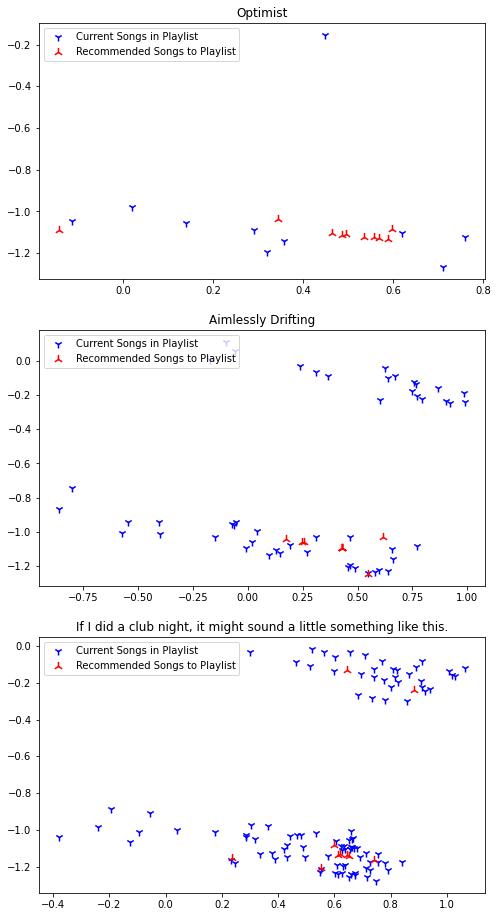

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting songs present in playlists compared to songs suggested 
fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


ax1.scatter(playlist_1_optimist_songs_x, playlist_1_optimist_songs_y, s=65, c='b', marker="1", label='Current Songs in Playlist')
ax1.scatter(playlist_1_optimist_rsongs_x, playlist_1_optimist_rsongs_y, s=85, c='r', marker="2", label='Recommended Songs to Playlist')

ax2.scatter(playlist_2_drifting_songs_x, playlist_2_drifting_songs_y, s=65, c='b', marker="1", label='Current Songs in Playlist')
ax2.scatter(playlist_2_drifting_rsongs_x, playlist_2_drifting_rsongs_y, s=85, c='r', marker="2", label='Recommended Songs to Playlist')

ax3.scatter(playlist_1_clubnight_songs_x, playlist_1_clubnight_songs_y, s=65, c='b', marker="1", label='Current Songs in Playlist')
ax3.scatter(playlist_1_clubnight_rsongs_x, playlist_1_clubnight_rsongs_y, s=85, c='r', marker="2", label='Recommended Songs to Playlist')

ax1.set_title('Optimist')
ax2.set_title('Aimlessly Drifting')
ax3.set_title('If I did a club night, it might sound a little something like this.')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

plt.show()
plt.savefig('Playlist-Song Recommendations')

Optimist

Aimlessly Drifting

If I did a club night, it might sound a little something like this.


## User - Song Recommendation

In [ ]:
joinedDF_1 = joinedDF_1.drop(dataDF2_dense.artistname).drop(dataDF2_dense.name)
joinedDF_1.show(2, truncate=False)

+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname                       |playlistname    |scaled_features                                                                                                                                                                                                         |
+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd55908290abee621a2851d48e37|Les Brown |'S Wonderful    

In [ ]:
joinedDF_1.createOrReplaceTempView('song_joined_table')
grouped_DF = joinedDF_1.groupBy('user_id').agg(countDistinct('trackname').alias('song_count'))
grouped_DF.show(2, truncate=False)

+--------------------------------+----------+
|user_id                         |song_count|
+--------------------------------+----------+
|e35a96394f62367a39560039b3bd29fc|490       |
|f9791ee3b4348aecdf3bf3b159dcadc3|441       |
+--------------------------------+----------+
only showing top 2 rows



User 1 - 56e91726c2059e73002ad3af15d8cd43 (15)

User 2 - f2c7bb9f74e06099854a4499946b02fd (35)

User 3 - 57718f1dbda00caa0bf6e1e3c12f59bf (55)

In [ ]:
# Finding random users by the number of distinct songs listened to
grouped_DF.filter(col('song_count') <= 15).sort(col('song_count').desc()).show(10, truncate=False)

+--------------------------------+----------+
|user_id                         |song_count|
+--------------------------------+----------+
|09b5c946893772d8d4a48712067b4e21|15        |
|845691a87f0f206798775e16ac2aeae1|15        |
|abdef26bda9ea920b72d9404dd2cd61c|15        |
|ed034726d95c6a2175c1c2ec7303a599|15        |
|56e91726c2059e73002ad3af15d8cd43|15        |
|062290789ceac1848aa5f34a1ab58002|15        |
|34333130a0c1cc8ede668ff3c5449885|15        |
|5edfdb4e8ec152427104c23a0ba2830b|15        |
|c7c3cacd016d8cf31724f75f833abfa1|15        |
|a28a6cd013f214032074ca1079dca1ee|15        |
+--------------------------------+----------+
only showing top 10 rows



In [ ]:
# ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = '57718f1dbda00caa0bf6e1e3c12f59bf' LIMIT 10").show(truncate=False)
ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = '56e91726c2059e73002ad3af15d8cd43' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").show()

+------------+-----------------+
|  artistname|count(artistname)|
+------------+-----------------+
|Lana Del Rey|               14|
|  The Champs|                1|
+------------+-----------------+



In [ ]:
# Collecting songs and artists information for the 3 users
user_1_song_track = ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = '56e91726c2059e73002ad3af15d8cd43' ").collect()
user_2_song_track = ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = 'f2c7bb9f74e06099854a4499946b02fd' ").collect()
user_3_song_track = ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = '57718f1dbda00caa0bf6e1e3c12f59bf' ").collect()

user_1_artist = ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = '56e91726c2059e73002ad3af15d8cd43' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").collect()
user_2_artist= ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = 'f2c7bb9f74e06099854a4499946b02fd' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").collect()
user_3_artist = ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = '57718f1dbda00caa0bf6e1e3c12f59bf' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").collect()

In [ ]:
# Mapping the joined df into a rdd to create profiles
joinedDF_1_rdd = joinedDF_1.rdd.map(list)
joinedDF_1_rdd.take(2)

[['8104bd55908290abee621a2851d48e37',
  'Les Brown',
  "'S Wonderful",
  'Jazz',
  DenseVector([0.8594, 0.58, 0.365, 0.0442, 0.0, 0.539, 0.0515, 0.6954, 0.0261, 0.7866, 0.0809, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])],
 ['872e0baf7655b1b3e3ead68e9707b455',
  'Four Tops',
  "(It's The Way) Nature Planned It",
  'Four Tops – The Definitive Collection',
  DenseVector([0.5412, 0.584, 0.604, 0.0559, 0.0042, 0.721, 0.3299, 0.3781, 0.0794, 0.8079, 0.0348, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]]

In [ ]:
# Creating song profiles by the user (by simple average of the songs the user listened to)

user_1_songs_profile = joinedDF_1_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                     .filter(lambda kv: kv[0] == '56e91726c2059e73002ad3af15d8cd43')\
                                     .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                     .map(lambda kv: kv[1][0] / kv[1][1])\
                                     .collect()
user_2_songs_profile = joinedDF_1_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                     .filter(lambda kv: kv[0] == 'f2c7bb9f74e06099854a4499946b02fd')\
                                     .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                     .map(lambda kv: kv[1][0] / kv[1][1])\
                                     .collect()
user_3_songs_profile = joinedDF_1_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                     .filter(lambda kv: kv[0] == '57718f1dbda00caa0bf6e1e3c12f59bf')\
                                     .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                     .map(lambda kv: kv[1][0] / kv[1][1])\
                                     .collect()

In [ ]:
# Finding recommendations for the above users based on their user profile using LSH

user_1_songs_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, user_1_songs_profile[0], 10, distCol='Distance_Measure').collect()
user_2_songs_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, user_2_songs_profile[0], 10, distCol='Distance_Measure').collect()
user_3_songs_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, user_3_songs_profile[0], 10, distCol='Distance_Measure').collect()

In [ ]:
# Getting the reduced features for the songs the model recommended to the users
user_1_rsongs = []
user_1_rsongs_x = []
user_1_rsongs_y = []

user_2_rsongs = []
user_2_rsongs_x = []
user_2_rsongs_y = []

user_3_rsongs = []
user_3_rsongs_x = []
user_3_rsongs_y = []

for i in user_1_songs_neighbours:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_rsongs.append((i.name, coordinate))
  user_1_rsongs_x.append(coordinate[0])
  user_1_rsongs_y.append(coordinate[1])

for i in user_2_songs_neighbours:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_rsongs.append((i.name, coordinate))
  user_2_rsongs_x.append(coordinate[0])
  user_2_rsongs_y.append(coordinate[1])

for i in user_3_songs_neighbours:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_rsongs.append((i.name, coordinate))
  user_3_rsongs_x.append(coordinate[0])
  user_3_rsongs_y.append(coordinate[1])

In [ ]:
# Getting the reduced features for the songs the users had listened to
user_1_lsongs = []
user_1_lsongs_x = []
user_1_lsongs_y = []

user_2_lsongs = []
user_2_lsongs_x = []
user_2_lsongs_y = []

user_3_lsongs = []
user_3_lsongs_x = []
user_3_lsongs_y = []

for i in user_1_song_track:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.trackname) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_lsongs.append((i.trackname, coordinate))
  user_1_lsongs_x.append(coordinate[0])
  user_1_lsongs_y.append(coordinate[1])

for i in user_2_song_track:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.trackname) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_lsongs.append((i.trackname, coordinate))
  user_2_lsongs_x.append(coordinate[0])
  user_2_lsongs_y.append(coordinate[1])

for i in user_3_song_track:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.trackname) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_lsongs.append((i.trackname, coordinate))
  user_3_lsongs_x.append(coordinate[0])
  user_3_lsongs_y.append(coordinate[1])

In [ ]:
# Getting the reduced features of the top artists the user had listened to

user_1_lartists = []
user_1_lartists_x = []
user_1_lartists_y = []

user_2_lartists = []
user_2_lartists_x = []
user_2_lartists_y = []

user_3_lartists = []
user_3_lartists_x = []
user_3_lartists_y = []

# Only need one artist joining condition
for i in user_1_artist:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_lartists.append((i.artistname, coordinate))
  user_1_lartists_x.append(coordinate[0])
  user_1_lartists_y.append(coordinate[1])

for i in user_2_artist:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_lartists.append((i.artistname, coordinate))
  user_2_lartists_x.append(coordinate[0])
  user_2_lartists_y.append(coordinate[1])

for i in user_3_artist:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_lartists.append((i.artistname, coordinate))
  user_3_lartists_x.append(coordinate[0])
  user_3_lartists_y.append(coordinate[1])

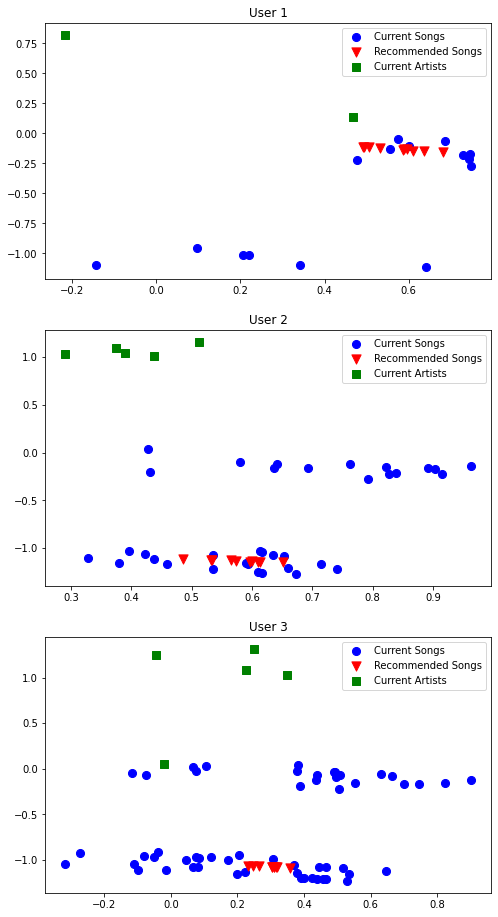

In [ ]:
# PLotting Recommendations
# from google.colab import files
fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


ax1.scatter(user_1_lsongs_x, user_1_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax1.scatter(user_1_rsongs_x, user_1_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs')
ax1.scatter(user_1_lartists_x, user_1_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax2.scatter(user_2_lsongs_x, user_2_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax2.scatter(user_2_rsongs_x, user_2_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs')
ax2.scatter(user_2_lartists_x, user_2_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax3.scatter(user_3_lsongs_x, user_3_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax3.scatter(user_3_rsongs_x, user_3_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs')
ax3.scatter(user_3_lartists_x, user_3_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax1.set_title('User 1')
ax2.set_title('User 2')
ax3.set_title('User 3')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.show()
# plt.savefig('User-Song Recommendations.png')
# files.download('User-Song Recommendations.png.pdf')

# Clustering before performing User - Song Recommendation

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel, KMeansSummary

In [ ]:
joinedDF_1.show(2, truncate=False)

+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname                       |playlistname    |scaled_features                                                                                                                                                                                                         |
+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd55908290abee621a2851d48e37|Les Brown |'S Wonderful    

In [ ]:
user_3_clusters = joinedDF_1.filter(col('user_id') == '57718f1dbda00caa0bf6e1e3c12f59bf').select(['trackname', 'scaled_features'])

In [ ]:
kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster_prediction', k=2, maxIter=10, distanceMeasure='euclidean')
model = kmeans.fit(user_3_clusters)
centers = model.clusterCenters()
summary = model.summary
summary.trainingCost

In [ ]:
center_1, center_2 = DenseVector(centers[0]), DenseVector(centers[1])

In [ ]:
# Getting recommendations from cluster centers
center_1_neighbour = brp_model_song.approxNearestNeighbors(dataDF2_hashed, center_1, 10, distCol='Distance_Measure').collect()
center_2_neighbour = brp_model_song.approxNearestNeighbors(dataDF2_hashed, center_2, 10, distCol='Distance_Measure').collect()

In [ ]:
# Getting 2-D coordinates of the song recommendations for both clusters
center_1_rsongs = []
center_1_rsongs_x = []
center_1_rsongs_y = []

center_2_rsongs = []
center_2_rsongs_x = []
center_2_rsongs_y = []

for i in center_1_neighbour:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  center_1_rsongs.append((i.name, coordinate))
  center_1_rsongs_x.append(coordinate[0])
  center_1_rsongs_y.append(coordinate[1])

for i in center_2_neighbour:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  center_2_rsongs.append((i.name, coordinate))
  center_2_rsongs_x.append(coordinate[0])
  center_2_rsongs_y.append(coordinate[1])

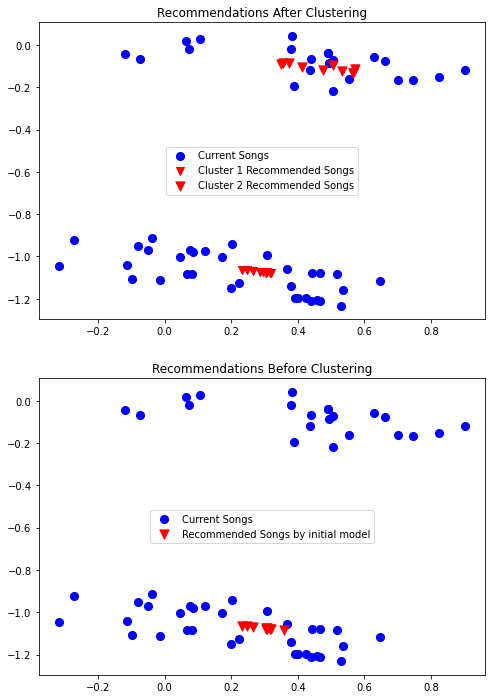

In [ ]:
# Comparing simple average vs clustered quering

fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(user_3_lsongs_x, user_3_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax1.scatter(center_1_rsongs_x, center_1_rsongs_y, s=65, c='r', marker="v", label='Cluster 1 Recommended Songs')
ax1.scatter(center_2_rsongs_x, center_2_rsongs_y, s=85, c='r', marker="v", label='Cluster 2 Recommended Songs')

ax2.scatter(user_3_lsongs_x, user_3_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax2.scatter(user_3_rsongs_x, user_3_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs by initial model')
# ax2.scatter(user_3_lartists_x, user_3_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax1.set_title('Recommendations After Clustering')
ax2.set_title('Recommendations Before Clustering')

ax1.legend(loc='center')
ax2.legend(loc='center')

plt.show()

# User Genre Tagging

In [ ]:
import time

In [ ]:
# Encode the genre dataframe into features and create their has projections
# Create user profiles of 3 randomly selected users (based on the distinct no of artists they listen to) and find similarity with hashed genres
# Can be used for user tagging (can be used as a part of bio for the user (similar to fb and twitter))
# Create user profiles from the joinedDF_1 and groupby user and calculate mean featuers and then hash projections to calculate similarity

In [ ]:
# Removing exlpicit from user profiles
# Ecoding the key variable into one hot encoded vector in the joined df

joinedDF_user_p = spotifydf.join(dataDF2,(dataDF2.name==spotifydf.trackname)&(dataDF2.artistname_1==spotifydf.artistname))
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model_1 = ohe.fit(joinedDF_user_p)
joinedDF_user_key_encoded = model_1.transform(joinedDF_user_p)

audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'key_vector']
                                    
joinedDF_user_key_encoded = joinedDF_user_key_encoded.select(['user_id', 'name', 'artistname', 'playlistname'] + audio_feature_columns)

# Assembling it into one vector

assembler_1 = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
joinedDF_user_feature = assembler_1.transform(joinedDF_user_key_encoded)
# dataDF2_feature.show(2, truncate=False)

# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model_2 = mmScaler.fit(joinedDF_user_feature)
joinedDF_user_feature = model_2.transform(joinedDF_user_feature)

In [ ]:
joinedDF_user_feature.show(2, truncate=False)

+--------------------------------+--------------------------------+----------+-------------------------------------+------------+------------------+------+------------------+----------------+-------+----------+------------------+--------+--------+-----------+----+--------------+----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |name                            |artistname|playlistname                         |acousticness|danceability      |energy|duration          |instrumentalness|valence|popularity|tempo             |liveness|loudness|speechiness|mode|key_vector    |features                                                       

In [ ]:
# Creating user profiles
joinedDF_user_feature_rdd = joinedDF_user_feature.select(['user_id', 'name', 'artistname', 'scaled_features']).rdd.map(list)
joinedDF_user_feature_rdd.take(2)

[['8104bd55908290abee621a2851d48e37',
  "'S Wonderful",
  'Les Brown',
  SparseVector(23, {0: 0.8594, 1: 0.58, 2: 0.365, 3: 0.0457, 4: 0.0, 5: 0.539, 6: 0.0588, 7: 0.6954, 8: 0.0261, 9: 0.8197, 10: 0.0815, 11: 1.0, 21: 1.0})],
 ['872e0baf7655b1b3e3ead68e9707b455',
  "(It's The Way) Nature Planned It",
  'Four Tops',
  SparseVector(23, {0: 0.5412, 1: 0.584, 2: 0.604, 3: 0.0579, 4: 0.0042, 5: 0.721, 6: 0.3765, 7: 0.3781, 8: 0.0795, 9: 0.8419, 10: 0.035, 11: 1.0, 13: 1.0})]]

In [ ]:
user_artist_count_master = joinedDF_user_feature_rdd.map(lambda l: ( (l[0],l[2]), 1 ))\
                                                    .filter(lambda kv: kv[0][0] == '57718f1dbda00caa0bf6e1e3c12f59bf')\
                                                    .reduceByKey(lambda a,b: a + b)\
                                                    .collect()

In [ ]:
user_artist_count_master[0]

(('57718f1dbda00caa0bf6e1e3c12f59bf', 'Maze'), 3)

In [ ]:
def getweights(t):
  for i in user_artist_count_master:
    if t[0] == i[0][0]:
      if t[1] == i[0][1]:
        return (t[0], (i[1]*t[-1], 1))

In [ ]:
user_profiles_1 = joinedDF_user_feature_rdd.map(lambda l: (l[0], l[2], DenseVector(l[-1].toArray()) ))\
                                            .filter(lambda kv: kv[0] == '57718f1dbda00caa0bf6e1e3c12f59bf')\
                                            .map(getweights)\
                                            .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                            .map(lambda kv: (kv[0], kv[1][0] / kv[1][1]))\
                                            .collect()

In [ ]:
# Calculating the user profile for all users based on the songs they listen to
start_time = time.time()
user_profiles = joinedDF_user_feature_rdd.map(lambda l: (l[0], (DenseVector(l[-1].toArray()), 1)))\
                          .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                          .map(lambda kv: (kv[0], kv[1][0] / kv[1][1]))\
                          .collect()
print("Time taken", time.time() - start_time)                       

Time taken 160.36447191238403


In [ ]:
for i in user_profiles:
  if i[0] == '57718f1dbda00caa0bf6e1e3c12f59bf':
    user_profile_vector = i[1] 
user_profile_vector

DenseVector([0.3527, 0.5845, 0.5172, 0.0956, 0.1267, 0.5863, 0.4603, 0.4751, 0.1855, 0.7882, 0.0524, 0.5614, 0.0877, 0.0, 0.0877, 0.0, 0.1228, 0.0877, 0.0351, 0.2105, 0.0, 0.193, 0.0877])

In [ ]:
genredf = ss.read.csv(genreDataPath,header=True,inferSchema=True)
genredf = genredf.withColumn("duration_ms",col("duration_ms")/60000).withColumnRenamed("duration_ms","duration")

ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model = ohe.fit(genredf)
genredf_key_encoded = model.transform(genredf)
# genredf_key_encoded.show(5, truncate=False)

audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'key_vector']
assembler = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
genredf_features = assembler.transform(genredf_key_encoded)
# genredf_features.show(5, truncate=False)

mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model = mmScaler.fit(genredf_features)
genredf_scaled = model.transform(genredf_features)

In [ ]:
# Convert to dense vector by rdd
genredf_scaled = genredf_scaled.filter(col('genres') != '[]')
genredf_scaled.show(2, truncate=False)

+----------+-------------------+------------------+------------------+-------------------+---------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|genres    |acousticness       |danceability      |duration          |energy             |instrumentalness     |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|k

In [ ]:
genredf_scaled_rdd = genredf_scaled.select(['genres', 'scaled_features']).rdd.map(list)
genredf_dense = genredf_scaled_rdd.map(lambda l: (l[0], DenseVector(l[1].toArray()))).toDF()
genredf_dense = genredf_dense.withColumnRenamed('_1', 'genres').withColumnRenamed('_2', 'scaled_features_dense')
genredf_dense.show(2, truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|genres    |scaled_features_dense                                                                                                                                                                                                                                               |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|432hz     |[0.4967654110346869,0.266837705489432,0.4493474134831647,0.6307622335474965,0.4816145833333333,0.22239874476236543,0.6361788617886179,0.478853085291079,0.120247568523

In [ ]:
# Creating Hash projections of genres
brp = BucketedRandomProjectionLSH(inputCol='scaled_features_dense', outputCol='hashed_projections', seed=123, numHashTables=5, bucketLength=10)
brp_model_genre = brp.fit(genredf_dense)
genredf_hashed = brp_model_genre.transform(genredf_dense)
genredf_hashed.show(2, truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|genres    |scaled_features_dense                                                                                                                                                                                                                                               |hashed_projections                   |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|432hz     |[0.4967654110346869,0.266837705489432,0.449347413483

In [ ]:
w_genredf = ss.read.csv(wgenresDataPath,header=True,inferSchema=True)
w_genredf.show(2, truncate=False)

+------------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------------+
|artists                             |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|genres        |
+------------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------------+
|"""Cats"" 1981 Original London Cast"|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18067

In [ ]:
# Getting the artists and genres of a selected user 
w_genredf.createOrReplaceTempView('genre_artist_table')
joinedDF_user_p.createOrReplaceTempView('song_joined_table_1')
artist_user3_list = ss.sql("SELECT artistname FROM song_joined_table_1 WHERE user_id = '57718f1dbda00caa0bf6e1e3c12f59bf' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
genre_names_user3 = []
for i in artist_user3_list:
  genre_names_user3.append(i.artistname)
# ss.sql("SELECT artists, genres FROM genre_artist_table WHERE artists == 'Bread' OR artists == 'Miles Davis' OR artists == 'Steely Dan' OR artists == 'Steely Dan' OR artists == 'Steely Dan'").show(truncate=False)

In [ ]:
w_genredf.filter(col('artists').isin(genre_names_user3)).select(['artists', 'genres']).show(truncate=False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists      |genres                                                                                                                                                             |
+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Boz Scaggs   |['adult standards', 'album rock', 'classic rock', 'country rock', 'folk', 'folk rock', 'mellow gold', 'roots rock', 'singer-songwriter', 'soft rock', 'yacht rock']|
|Bread        |['adult standards', 'folk', 'folk rock', 'mellow gold', 'soft rock']                                                                                               |
|China Crisis |['art rock', 'dance rock', 'new romantic', 'new wave', 'new wave pop', 'synthpop']   

In [ ]:
# Finding the genre tag of the selected user 
brp_model_genre.approxNearestNeighbors(genredf_hashed, user_profiles_1[0][1], 10, distCol='Distance_Measure').show()

+-----------------+---------------------+--------------------+-----------------+
|           genres|scaled_features_dense|  hashed_projections| Distance_Measure|
+-----------------+---------------------+--------------------+-----------------+
|      ukg revival| [0.02630201432791...|[[0.0], [0.0], [0...|9.397137144600748|
| folklore peruano| [0.63805101687483...|[[-1.0], [0.0], [...|9.435207454217926|
|  panamanian rock| [0.06877203370709...|[[-1.0], [0.0], [...|  9.4723833793897|
|          circuit| [0.00906300173358...|[[0.0], [0.0], [0...|9.475702969159096|
|         guaracha| [0.00906300173358...|[[0.0], [0.0], [0...|9.475702969159096|
|             coco| [0.58019440064019...|[[0.0], [0.0], [-...|9.488919912954218|
| cumbia paraguaya| [0.20331062937636...|[[-1.0], [0.0], [...|9.497632907682734|
|              vbs| [0.34181510155977...|[[0.0], [0.0], [0...|9.499870928295916|
|   cumbia villera| [0.19941726537234...|[[-1.0], [0.0], [...|9.503039823822188|
|musica ayacuchana| [0.68373

## Creating user profile using the artists

In [ ]:
# Creating user profiles based on the artists the user has listened to 

In [ ]:
joined_artist_df_rdd = joined_artist_df_id.rdd.map(list)
# joined_artist_df_rdd.map(lambda l: l[-1].shape).take(2)

user_3_artist_profile_id = joined_artist_df_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == '57718f1dbda00caa0bf6e1e3c12f59bf')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()

In [ ]:
# User Profile created soley based on song features
user_profile_vector
# User profile created soley based on artist features
user_3_artist_profile_id[0]
# User profile created based on weighted song features (weights assigned to songs based on artists count)
user_profiles_1[0][1]

DenseVector([0.3378, 0.5973, 0.5273, 0.0493, 0.2029, 0.5458, 0.4078, 0.5343, 0.1748, 0.7986, 0.0551, 0.7391, 0.1377, 0.0797, 0.1413, 0.0217, 0.0036, 0.0725, 0.1232, 0.1812, 0.0688, 0.0978, 0.0145])

In [ ]:
user_profile_vector

DenseVector([0.3527, 0.5845, 0.5172, 0.0956, 0.1267, 0.5863, 0.4603, 0.4751, 0.1855, 0.7882, 0.0524, 0.5614, 0.0877, 0.0, 0.0877, 0.0, 0.1228, 0.0877, 0.0351, 0.2105, 0.0, 0.193, 0.0877])

In [ ]:
# Genre Prediction based soley on song features
brp_model_genre.approxNearestNeighbors(genredf_hashed, user_profile_vector, 10, distCol='Distance_Measure').show()

+--------------------+---------------------+--------------------+------------------+
|              genres|scaled_features_dense|  hashed_projections|  Distance_Measure|
+--------------------+---------------------+--------------------+------------------+
|          dutch rock| [0.32657197907238...|[[-1.0], [0.0], [...|0.5797586550139888|
|         quiet storm| [0.30485968092295...|[[-1.0], [0.0], [...|0.5882001536244413|
|        jovem guarda| [0.49322538345723...|[[-1.0], [0.0], [...|0.5999131569816505|
|          piano rock| [0.38457228674870...|[[-1.0], [0.0], [...|0.6076507637694536|
|     one-person band| [0.43322145010009...|[[-1.0], [0.0], [...|0.6077361044673869|
|            neo soul| [0.27371523916278...|[[-1.0], [0.0], [...|0.6077947500393084|
|      new jack swing| [0.22967488141549...|[[-1.0], [0.0], [...|0.6081093895878967|
|          synth funk| [0.22209466131717...|[[-1.0], [0.0], [...|0.6082128188083553|
|sertanejo univers...| [0.49951663328101...|[[-1.0], [0.0], [...|

In [ ]:
# Finding the closest genres that explains the users taste in music based on the artists the user listens to 
brp_model_genre.approxNearestNeighbors(genredf_hashed, user_3_artist_profile_id[0], 10, distCol='Distance_Measure').show()

+--------------------+---------------------+--------------------+-------------------+
|              genres|scaled_features_dense|  hashed_projections|   Distance_Measure|
+--------------------+---------------------+--------------------+-------------------+
|          dutch rock| [0.32657197907238...|[[-1.0], [0.0], [...|0.46017068572104947|
|          synth funk| [0.22209466131717...|[[-1.0], [0.0], [...|0.49302179359458764|
|         quiet storm| [0.30485968092295...|[[-1.0], [0.0], [...| 0.4967222745612981|
|alternative ameri...| [0.31995162355459...|[[-1.0], [0.0], [...| 0.5001752639488984|
|south carolina indie| [0.40285497145420...|[[-1.0], [0.0], [...| 0.5034827246803009|
|     one-person band| [0.43322145010009...|[[-1.0], [0.0], [...| 0.5060414154324744|
|          piano rock| [0.38457228674870...|[[-1.0], [0.0], [...|  0.509639118268468|
|        jovem guarda| [0.49322538345723...|[[-1.0], [0.0], [...| 0.5151677217040239|
|  south african jazz| [0.43058203297696...|[[-1.0], [

In [ ]:
# Finding the closest genres that explains the users taste in music based on a weighted average of song and artists
brp_model_genre.approxNearestNeighbors(genredf_hashed, user_profiles_1[0][1], 10, distCol='Distance_Measure').show()

+-----------------+---------------------+--------------------+-----------------+
|           genres|scaled_features_dense|  hashed_projections| Distance_Measure|
+-----------------+---------------------+--------------------+-----------------+
|      ukg revival| [0.02630201432791...|[[0.0], [0.0], [0...|9.397137144600748|
| folklore peruano| [0.63805101687483...|[[-1.0], [0.0], [...|9.435207454217926|
|  panamanian rock| [0.06877203370709...|[[-1.0], [0.0], [...|  9.4723833793897|
|          circuit| [0.00906300173358...|[[0.0], [0.0], [0...|9.475702969159096|
|         guaracha| [0.00906300173358...|[[0.0], [0.0], [0...|9.475702969159096|
|             coco| [0.58019440064019...|[[0.0], [0.0], [-...|9.488919912954218|
| cumbia paraguaya| [0.20331062937636...|[[-1.0], [0.0], [...|9.497632907682734|
|              vbs| [0.34181510155977...|[[0.0], [0.0], [0...|9.499870928295916|
|   cumbia villera| [0.19941726537234...|[[-1.0], [0.0], [...|9.503039823822188|
|musica ayacuchana| [0.68373

According to the artists this user listens to we can infer that the user at large likes the following genre of music:


*   Rock - folk rock, country rock, etc ..
*   Jazz - funk, classic jazz etc.. 

The genres provided by the artist profiles are as follows:



1.   Profile build soley using song features

> *   dutch rock
 
> *   quiet storm

> *   jovem guarda


2.   Profile build soley based on artist features 

> *   dutch rock
 
> *   synth funk

> *   quiet storm

3.   Profile build by taking a weighted average of songs and artist (weighing the features of songs more if that song is from a artist that the user frequently listens to)

> *   ukg revival
 
> *   folklore peruano

> *   panamanian rock






# User - Artist Recommendation using Matrix Factorization

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
# Model evaluation with increasing rank
# Model evaluation with increasing value of alpha. The alpha parameter controls the confidence in the positive feedback. 
# The relation of the confidence and alpha is given as follows: c = 1 + alpha*r(u,i) -> r(u,i) is the implicit feed back given by user u for item i
# The matrix maps any (r(u,i) > 0 -> 1) and (r(u,i) = 0 -> 0) and formulates a binary feedback to each user item interaction
# (https://ieeexplore.ieee.org/document/4781121/authors#authors)

In [ ]:
spotifydf = ss.read.csv(spotifyDataPath,header=True,inferSchema=True)
spotifydf = spotifydf.select('user_id',col(' "artistname"').alias('artistname'), col(' "trackname"').alias("trackname"),col(' "playlistname"').alias('playlistname'))
spotifyRDD = spotifydf.rdd.map(list) 
artistdf = ss.read.csv(artistDataPath,header=True,inferSchema=True)
# artistdf.printSchema()
artistdf.show(2, truncate=False)

+------------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+
|artists                             |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|
+------------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+
|"""Cats"" 1981 Original London Cast"|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18067500000000009|115.9835          |0.33443333333

In [ ]:
artistdf = artistdf.withColumn('artists',translate('artists', '"','')).withColumn('artists',translate('artists', '”', ''))
artistdf.select('artists').show(2, truncate=False)
artistdf.printSchema()

+------------------------------+
|artists                       |
+------------------------------+
|Cats 1981 Original London Cast|
|Cats 1983 Broadway Cast       |
+------------------------------+
only showing top 2 rows

root
 |-- artists: string (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- count: integer (nullable = true)



In [ ]:
# Total number of distinct users and artists in our dataset
unique_users = spotifyRDD.map(lambda l: l[0]).distinct().count()
unique_artists = spotifyRDD.map(lambda l: l[1]).distinct().count()

print("The number of unique users in the spotify playlist dataset is ", unique_users)
print("The number of unique artists in the spotify playlist dataset is ", unique_artists)

The number of unique users in the spotify playlist dataset is  15918
The number of unique artists in the spotify playlist dataset is  289816


In [ ]:
# Creating users and artists dictionaries
user_dic = {}
artists_dic = {}
users_list = spotifyRDD.map(lambda l: l[0]).distinct().collect()
artists_list = spotifyRDD.map(lambda l: l[1]).distinct().collect()

for index, user in enumerate(users_list):
  user_dic[user] = index
for index, artists in enumerate(artists_list):
  artists_dic[artists] = index

In [ ]:
# Creating (user, artist, count) raiting tuples for the ALS model to train on
user_artist_rdd = spotifyRDD.map(lambda l: ((user_dic[l[0]], artists_dic[l[1]]), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda kv: Rating(int(kv[0][0]), int(kv[0][1]), int(kv[1])))

In [ ]:
# Splitting the original rdd into training and testing rdd randomly in proportion of 60-40
training_rdd, testing_rdd = user_artist_rdd.randomSplit([0.6, 0.4], 10)

In [ ]:
# Mapping our testing rdd to binary inputs
def confidence(r):
  if r.rating > 0:
    return Rating(r.user, r.product, 1)
  else:
    return Rating(r.user, r.product, 0)
    
testing_rdd = testing_rdd.map(confidence)

In [ ]:
testing_rdd_1 = testing_rdd.map(lambda r: (r.user, r.product))

Training Log:

Parameters: rank (=10) and iterations (=10)

MSE: 
alpha (0.0001) - 0.8391973259581571

alpha (0.001) - 0.8394621245021734

alpha (0.01) - 0.839114778736289

alpha (0.1) - 0.8714874682599405

alpha (1) - 0.9999811140655851

alpha (10) - 1

Parmeters: rank (=20) and iterations (=10) alpha (=0.01)

MSE - 0.8152529887243596

In [ ]:
alpha = 0.0001
rank = 10
numIterations = 10

model = ALS.trainImplicit(training_rdd, rank, numIterations, alpha)
predictions = model.predictAll(testing_rdd_1).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = testing_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.8391973259581571


In [ ]:
alpha = 0.001
rank = 10
numIterations = 10

model = ALS.trainImplicit(training_rdd, rank, numIterations, alpha)
predictions = model.predictAll(testing_rdd_1).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = testing_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.8394621245021734


In [ ]:
a = [0.839114778736289, 0.8152529887243596]

In [ ]:
# Building an implict ALS model based on the number of times 
# alpha = 0.01
# rank = 500
# numIterations = 10

# model = ALS.trainImplicit(training_rdd, rank, numIterations, alpha)
# predictions = model.predictAll(testing_rdd_1).map(lambda r: ((r[0], r[1]), r[2]))
# ratesAndPreds = testing_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
# rank_MSE_1.append(MSE)
# print("Mean Squared Error = " + str(MSE))

In [ ]:
rank_MSE_1

[0.839114778736289,
 0.8152529887243596,
 0.8021789685727874,
 0.7946116267339124,
 0.7612373931533974]

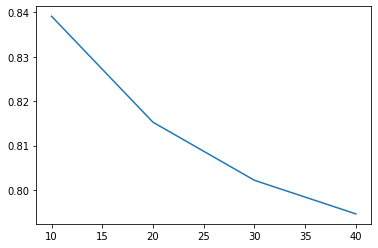

In [ ]:
rank_list = [10,20,30,40,100,500,1000]
plt.plot(rank_list, rank_MSE_1)
plt.show()

In [ ]:
alpha = 0.1
rank = 10
numIterations = 10

model = ALS.trainImplicit(training_rdd, rank, numIterations, alpha)
predictions = model.predictAll(testing_rdd_1).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = testing_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.8714874682599405


In [ ]:
alpha = 1.0
rank = 10
numIterations = 10

model = ALS.trainImplicit(training_rdd, rank, numIterations, alpha)
predictions = model.predictAll(testing_rdd_1).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = testing_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.9999811140655851


In [ ]:
alpha = 10.0
rank = 10
numIterations = 10

model = ALS.trainImplicit(training_rdd, rank, numIterations, alpha)
predictions = model.predictAll(testing_rdd_1).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = testing_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 1.0


In [ ]:
# Plotting MSE with the increasing number of rank
plt.plot(rank_list, rank_MSE)
plt.show()

In [ ]:
sc.stop()

In [ ]:
ss.stop()